<br><br><br><br><font size="6">Análise Longitudinal do Corpus de Cartas Brasileiras (PHPB-Ba)</font>

<p><font size="5" color="darkred">Valter Moreno</font><br/>
   <a href=mailto:valter.moreno@eng.uerj.br>valter.moreno@eng.uerj.br</a></p>

<font size="3" color="gray">**Fundação Getúlio Vargas (FGV)**<br/>
**Escola de Matemática Aplicada (EMAp)**<br/>
**Mestrado em Matemática Aplicada**<br/>
**Sistemas de Recuperação de Informação - 2019**<br/>
**Prof. Flavio Codeço**<br/></font>

<font size="4" id="tocheading">Índice</font>
<div id="toc"></div>
<br>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Objetivos do projeto

Neste projeto, analisamos os manuscritos modernizados do Corpus Eletrônico de Documentos Históricos do Sertão [(CE-DOHS)](http://www.tycho.iel.unicamp.br/cedohs/corpora.html) com os seguintes objetivos:

  - identificar os principais assuntos tratados nos documentos; e
  - avaliar semanticamente o seu conteúdo, ou seja, o significado das palavras de seu vocabulário.
  
Além de obtermos resultados globais para todo o corpus, dividimos os documentos de acordo com as décadas de sua produção, de forma a avaliar mudanças em assuntos e no significado de palavras ao longo do tempo.  

## Corpus analisado

O Corpus Compartilhado Diacrônico – Cartas Brasileiras (PHPB-Ba) é disponibilizado no website do projeto Plataforma Corpus Eletrônico de Documentos Históricos do Sertão [CE-DOHS](http://www5.uefs.br/cedohs/). O projeto é coordenado por Zenaide de Oliveira Novais Carneiro (UEFS/Fapesb/CNPq) e Mariana Fagundes de Oliveira Lacerda (UEFS/Fapesb).

O corpus analisado neste projeto consiste de **1.185 cartas** com datas no período de **1823 a 2000**. As cartas provêm de 14 corporas distintos, listados no [website do CE-DOHS](http://www.tycho.iel.unicamp.br/cedohs/corpora.html).

## Software utilizado

In [2]:
import numpy as np
import os
import glob
import re

import pandas as pd
pd.set_option('precision', 5)
pd.set_option('display.max_colwidth', -1) # Customização do display de dataframes para que
                                          # todo o conteúdo das colunas seja mostrado
import matplotlib.pyplot as plt
%config InteractiveShellApp.pylab_import_all = False
%pylab inline

import seaborn as sns
sns.set(palette='dark', color_codes=True)

from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go

from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE

from collections import defaultdict, Counter
from datetime import datetime
from pprint import pprint
from wordcloud import WordCloud
from string import punctuation
from random import randint, sample

# Gensim
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel, LsiModel, Word2Vec, word2vec
from gensim.corpora import MmCorpus
from gensim.test.utils import datapath, get_tmpfile

# spaCy
import spacy
nlp = spacy.load("pt_core_news_sm")

# NLTK
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Avisos:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vmoreno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Função para a impressão de conteúdo Markdown
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

## Importação dos textos do corpus

O corpus de 1.185 cartas está dividido em arquivos de texto com o conteúdo original e modernizado.  Em nossa análise, utilizamos apenas as cartas com o português modernizado. Um exemplo de manuscrito modernizado é mostrado a seguir.

In [4]:
caminho = "CE-DOHS/*.txt"
arquivos  = glob.glob(caminho)
printmd('**Há um total de <font color="gray">' + str(len(arquivos)) + '</font> arquivos no diretório do corpus.**\n')
printmd('**Nomes dos primeiros arquivos:**')
for i in range(0,8):
    print(arquivos[i])

**Há um total de <font color="gray">2370</font> arquivos no diretório do corpus.**


**Nomes dos primeiros arquivos:**

CE-DOHS/01-AAD-17-04-1962-mod.txt
CE-DOHS/01-AAD-17-04-1962-orig.txt
CE-DOHS/01-ACST-14-01-1952-mod.txt
CE-DOHS/01-ACST-14-01-1952-orig.txt
CE-DOHS/01-AFS-28-04-1956-mod.txt
CE-DOHS/01-AFS-28-04-1956-orig.txt
CE-DOHS/01-APACA-14-01-1980-mod.txt
CE-DOHS/01-APACA-14-01-1980-orig.txt


In [5]:
arquivos = [id for id in arquivos if id.endswith('-mod.txt')]

In [6]:
printmd('**<br/>Conteúdo do primeiro arquivo com português modernizado:**')
with open(arquivos[0]) as f:
    texto = [linha.strip(' \n') for linha in f.readlines() if len(linha.strip(' \n')) > 0] 
pd.DataFrame(texto, columns=['']).style.set_properties(**{'text-align': 'left'})

**<br/>Conteúdo do primeiro arquivo com português modernizado:**

## Extração de metadados e texto dos arquivos

Os arquivos do CE-DOHS incluem metadados em seu cabeçalho identificados pela sequência de caracteres `|:|`. Os seguintes campos são fornecidos:

  * Identificação do corpus
  * Nome da pesqisadora  
  * Identificação da carta
  * Nome do autor da carta
  * Nome do destinatário
  * Data da carta
  * Identificação de carta modernizada
  * Identificação da codificação (UTF-8)
  * Número da carta
  * Descrição do manuscrito (ex., local de arquivo, tipo de papel)
  
Destes, optamos por manter a identificação da carta, o rementente e o destinatário, e a data. Calculamos também o número de palavras em cada documento. Esses metadados foram armazenados num dataframe, confome mostrado posteriormente. 

In [7]:
printmd('**Metadados do primeiro arquivo:**')
pprint([meta for meta in texto if meta.startswith('|:|')])

**Metadados do primeiro arquivo:**

['|:| Corpus Eletrônico de Documento Históricos do Sertão [ CE-DOHS ]',
 '|:| Bruna Trindade',
 '|:| Carta 01-AAD-17-04-1962',
 '|:| Autor: Arnaldo Andrade Dias (apócrifo)',
 '|:| Destinatário: Maria de Lourdes de Lima Oliveira',
 '|:| Data: 17/04/ 1962',
 '|:| Versão modernizada',
 '|:| Encoding: UTF-8']


Para otimizar o uso da memória do computador, criamos uma classe que, quando instanciada, processa os documentos do corpus iterativamente, extraindo os metadados e gravando o texto processado num novo arquivo. O texto de cada carta foi processado da seguinte forma:

  * removemos espaços desnecessários dos nomes dos remetentes e destinatários; 
  * tranformamos as cadeias de caracter das datas originais em datas;
  * removemos o cabeçalho, com os metadados do arquivo; parte deles foi aproveitada para preencher os valores de identificação da carta, autor, destinatário, e data;
  * removemos o texto explicativo geralmente adicionado a cada carta, com informações tais como o tipo de papel usado, o número de folhas, onde a carta estava guardada, etc.
  * removemos notas inseridas no manuscrito para identificar mudanças de página, rasuras, borrados, etc.
  * removemos notas de rodapé, tipicamente explicando que anotações foram feitas no manuscrito
  * separamos trechos demarcados por quebras de linha e pontuações (ponto final, de exclação e de interrogação, ponto e vírgula, e travessão) em linhas. 

In [8]:
class CartasCorpus:
    def __init__(self, arquivos, pasta, ndocs=100, inicio=10):
        self.arquivos = arquivos
        self.pasta = pasta
        self.ndocs = min(len(arquivos),ndocs)
        self.inicio = inicio
    '''
    Para cada os ndocs primeiros arquivos do corpus, os metadados são extraídos e adicionados
    ao dataframe passado na criação do objeto. Além disso, o conteúdo do arquivo é processado 
    de acordo com o tipo de processamento especificado, e gravado num arquivo com o mesmo ID do
    arquivo original e o sufixo "-proc.txt".
    '''    
    def __iter__(self):
        for fileid in self.arquivos[:self.ndocs]:
            meta_dic = dict()            
            
            ''' Lê o conteúdo do arquivo numa lista de linhas:
            '''
            with open(fileid, mode="r", encoding="utf-8") as doc:
                texto = doc.read()
                
            linhas = [linha for linha in texto.split('\n') if len(linha) > 0]
            
            ''' Cria um dicionário a partir das linhas de metadados:
            '''
            meta_dic['ID'] = fileid.replace('CE-DOHS/','').replace('-mod.txt','')
            
            meta_dic['Palavras'] = len(texto.split())
                        
            rem = [autor.replace(u'|:| Autor:', '').strip(' .\n') \
                   for autor in linhas \
                   if u'|:| Autor:' in autor][0]
            meta_dic['Remetente'] = rem if len(rem) > 0 else np.NaN
            
            dest = [dest.replace(u'|:| Destinatário:', '').strip(' .\n') \
                    for dest in linhas \
                    if u'|:| Destinatário:' in dest][0]
            meta_dic['Destinatário'] = dest if len(dest) > 0 else np.NaN
            
            ''' Tenta obter a data da carta:
            '''
            data = [data.replace(u'|:| Data:', '').strip(' .\n').lower() \
                    for data in linhas \
                    if u'|:| Data:' in data][0]
            meses = ['janeiro','fevereiro','mar','abril','maio','junho',
                     'julho','agosto','setembro','outubro','novembro','dezembro'] 
            mes = [mes for mes in meses if mes in data]
            if mes:
                data = data.replace(mes[0], '/' + str(meses.index(mes[0]) + 1) + '/')
            data_num = re.compile('[0-9\/]')
            data = data_num.findall(data)
            data = ''.join(data)
            try:
                data_dt = pd.to_datetime(data, infer_datetime_format=True)
                if pd.isna(data_dt) or data_dt.year > 2000 or data_dt.year < 1823:
                    data = self.data_id(fileid)
                else:
                    data = data_dt.strftime("%d/%m/%Y")
            except:
                data = self.data_id(fileid)
            meta_dic['Data'] = data
                
            ''' Processa as linhas e retorna uma nova lista com elementos do
                tipo especificado:
            '''
            texto = self.proc_texto(linhas, self.inicio)

            filtradas = 0
            for linha in texto:
                filtradas += len(linha.split())
            meta_dic['Filtradas'] = filtradas
            
            ''' Grava o arquivo com o texto processado no diretório 'CE-DOHS-proc/':
            '''
            if not os.path.exists(self.pasta):
                os.makedirs(self.pasta)
                
            nome = self.pasta + meta_dic['ID'] + '-proc.txt'
            with open(nome,'w+') as arquivo:
                arquivo.writelines("%s\n" % linha for linha in texto)                    
            
            yield meta_dic
                    
    def data_id(self, fileid):
        '''
        No corpus Corpus Eletrônico de Documentos Históricos do Sertão, a maior parte dos
        nomes dos arquivos inclui a data da carta. Esta função tenta recuperar essa data 
        a partir do nome do arquivo. O resultado gerado é um objeto to tipo datetime ou NaN.
        '''
        data_num = re.compile('[0-9]{2}-[0-9]{2}-[0-9]{4}')
        data = data_num.findall(fileid)
        if data:
            try:
                data_dt = pd.to_datetime(data[0], format='%d-%m-%Y')
                if pd.isna(data_dt):
                    return np.NaN
                else:
                    return data_dt.strftime("%d/%m/%Y") 
            except:
                return np.NaN
        else:
            return np.NaN

    def proc_texto(self, linhas, inicio):
        '''
        Processa cada linha do conteúdo do documento, a partir da linha de inicial passada (inicio),
        de acordo com o tipo de processamento especificado. Retorna uma lista com os resultados.
        '''
        ''' Converte as linhas do texto num único string:
        '''
        texto = linhas[inicio:len(linhas)]
        texto = '\n'.join(texto)
        
        ''' Elimina caracteres e comentários indesejáveis:
        '''
        texto = texto.replace('[pag]', '')
        texto = re.sub('\[footer:([\\n a-zA-Z0-9áàâãéèêíïóôõöúçñÁÀÂÃÉÈÍÏÓÔÕÖÚÇÑ.,!?;:<>()-_#\'\"‘’“”]*)\]',
                                 '', texto)
        texto = re.sub('\[header:[ ]*\]', '\n', texto)
        texto = re.sub('[|]*[ ]*[Ff]l. [0-9] [rv]', ' ', texto)
        texto = re.sub('[0-9][ ]*Rasura[do]*[ .]*', ' ', texto)
        texto = re.sub('[0-9][ ]*Borrado[ .]*', ' ', texto)
        texto = re.sub('\[[ ]*[Rr]ubrica[ ]*\]', ' ', texto)
        texto = re.sub('\[[ ]*[Rr]asura[ ]*\]', ' ', texto)
        texto = re.sub('\[[ ]*[Ii]nint[ ]*.[ ]*\]', ' ', texto)
        texto = re.sub('Sr. ', 'Sr ', texto)
        texto = re.sub('Sra. ', 'Sra ', texto)
        texto = re.sub('Dr. ', 'Dr ', texto)
        texto = re.sub('Dra. ', 'Dra ', texto)
        texto = re.sub('V. ', 'V ', texto)
        texto = re.sub('Exa. ', 'Exa ', texto)
        texto = re.sub(' = ', '', texto)
        texto = re.sub(u'[↑¹²³⁴⁵⁶⁷⁸⁹|<>\(\)\[\]‘’“”\'\"]+', '', texto)
        texto = re.sub(r' +', ' ', texto)
        texto = texto.strip()
        
        linhas = [linha for linha in texto.split('\n') if len(linha) > 0]
        linhas = self.quebra_linhas(linhas, ['?', '!', '.', ';', '–'])
        
        return linhas
    
    def quebra_linhas(self, linhas, pontos):
        for ponto in pontos:
            novas = []
            for linha in linhas:
                if ponto in linha:
                    linha=linha.replace(ponto, ' ' + ponto + '\n')
                    novas.extend([l.strip() 
                                  for l in linha.split('\n') 
                                  if len(l.strip(punctuation).strip()) > 0])
                else:
                    if len(linha.strip(punctuation).strip()) > 0:
                        novas.extend([linha.strip()])
            linhas = [linha for linha in novas]

        return novas

Instanciamos a classe criando um objeto que se comporta como um iterador. O processamento dos textos do corpus só é efetivamente realizado ao longo das iterações do *loop* `for doc in dic:` no trecho de código a seguir.

In [9]:
metadados = pd.DataFrame(columns=['ID', 'Palavras', 'Filtradas', 'Remetente', 'Destinatário', 'Data'])

dic = CartasCorpus(arquivos, 'CE-DOHS-proc/', ndocs=10000)

for doc in dic:
    metadados = metadados.append(doc, ignore_index=True)

Abaixo, motramos o dataframe com os resultados da extração dos metadados dos textos do corpus.

In [10]:
metadados

ID Palavras Filtradas  \
0     01-AAD-17-04-1962    243      169        
1     01-ACST-14-01-1952   349      267        
2     01-AFS-28-04-1956    256      181        
3     01-APACA-14-01-1980  469      393        
4     01-ASA-14-05-1955    221      139        
...                 ...    ...      ...        
1180  98-VOV-28-11-1934    404      325        
1181  99-AJN-26-05-1878    279      196        
1182  99-DCO               219      112        
1183  99-HRS-01-01-1931    483      397        
1184  99-VOV-18-03-1935    291      219        

                                Remetente  \
0     Arnaldo Andrade Dias (apócrifo)       
1     Antonio Carneiro da Silva Tuy         
2     Antonio Fortunato da Silva            
3     Adelmário Carneiro de Araújo          
4     Acioly Silva Araújo                   
...                   ...                   
1180  Virginia Ottoni Vieira                
1181  Antonio Jose Nogueira                 
1182  Doralice Carneiro de Oliveira Jesus   
1183  Hermínio Reis [Silva]                 
1184  Virginia Ottoni Vieira                

                                    Destinatário        Data  
0     Maria de Lourdes de Lima Oliveira           17/04/1962  
1     Maria de Souza Estrela                      14/01/1952  
2     João Carneiro de Oliveira                   28/04/1956  
3     Eliana de Oliveira Lima                     14/01/1980  
4     Dantas Junior                               14/05/1955  
...             ...                                      ...  
1180  Yáyá                                        28/11/1934  
1181  Doutor Martim Francisco Ribeiro de Andrade  26/05/1878  
1182  Zenilta Bispo de Oliveira                   NaN         
1183  Dantas Junior                               01/01/1931  
1184  Yáyá                                        18/03/1935  

[1185 rows x 6 columns]

O conteúdo processado de um arquivo escolhido aleatoriamente é exibido a seguir.

In [11]:
id = metadados.ID[randint(0, 1184)]

fileid = 'CE-DOHS-proc/' +  id + '-proc.txt'

with open(fileid, mode="r", encoding="utf-8") as doc:
    linhas = [linha.strip('\n') for linha in doc.readlines()]

printmd('**Carta ' + id + ':**')

for linha in linhas:
    pprint(linha)

**Carta 14-ATW-19-10-1933:**

'Bahia , 19 de Outubro 1933'
'Cara Maria'
('Tive o prazer de ter boas notícias suas e de todos daí pela sua carta a '
 'Mamãezinha , recebida hoje  .')
'Com que Mariana ainda não fez ponto final no povoamento do sólo  ;'
'coitada  !'
'é tempo de descançar , pois a tarefa que já têm , é o bastante  .'
'Felizmente ela está passando bem e é de esperar que nada tenha  .'
'Aqui todos bons  ;'
'os meninos já bem , e as meninas frequentando o Colégio  ;'
'Maria Luiza é que ainda não tem muito apetite  .'
'Hoje mesmo os meninos passaram toda a tarde aqui 1 e brincaram muito  .'
'Maria anda muito triste e abatida porque diz ela estar tudo'
'para saber o que haviam resolvido  .'
('Ela me respondeu que ficou resolvido não haver Festa nem no Parque nem na '
 'Casa , e sim fazer no dia 16 de Novembro um dia da Margarida 3 vendendo se '
 'esta flôr com toda a cidade  .')
('Mais , a tombola de uma frigidaire e pedir ao Prefeito licença para armar '
 'uma barraca no jardim da Piedade para Kermesse e R

## Análise exploratória dos metadados

Os documentos do corpus são cartas, geralmente de tamanho reduzido, como mostram o histograma e as estatísticas descrivas abaixo. Setenta e cinco por cento das cartas têm até 455 palavras, incluindo o cabeçalho com os metadados (nome do corpus, pessoa responsável, identificação da carta, autor, destinatário, data, versão, e codificação).

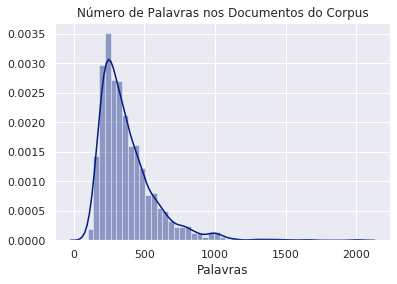

In [12]:
ax = sns.distplot(metadados.Palavras)
ax.set_title('Número de Palavras nos Documentos do Corpus')
plt.show()

In [13]:
printmd('**Estatísticas descritivas do número de palavras:**')
print(round(pd.to_numeric(metadados.Palavras).describe(),1))

**Estatísticas descritivas do número de palavras:**

count    1185.0
mean     375.8 
std      201.0 
min      99.0  
25%      239.0 
50%      323.0 
75%      455.0 
max      2007.0
Name: Palavras, dtype: float64


Uma vez que o pré-processamento dos textos incluiu a eliminação de metadados e comentários incluídos nos documentos originais, o número de palavras nos documentos processados é menor do que nos originais.

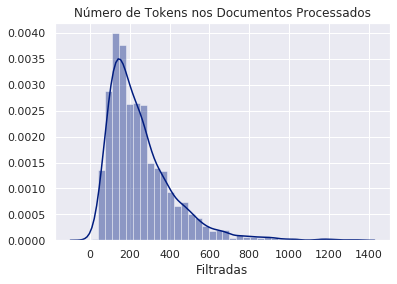

In [14]:
ax = sns.distplot(metadados.Filtradas)
ax.set_title('Número de Tokens nos Documentos Processados')
plt.show()

In [15]:
printmd('**Estatísticas descritivas para os documentos processados:**')
print(round(pd.to_numeric(metadados.Filtradas).describe(),1))

**Estatísticas descritivas para os documentos processados:**

count    1185.0
mean     253.9 
std      167.3 
min      7.0   
25%      137.0 
50%      210.0 
75%      324.0 
max      1324.0
Name: Filtradas, dtype: float64


### Número de cartas por ano

Uma vez que desejávamos avaliar as diferenças entre tópicos e significados de palavras ao longo tempo, era importante avaliar como os textos analisados estavam distribuídos ao longo do período compreendido no corpus (1823-2000). O gráfico a seguir mostra a evolução do número de cartas disponíveis em cada ano desse período. 

In [16]:
anos = [data[-4:] if not pd.isnull(data) else np.nan for data in metadados.Data.tolist()]
anos = [int(ano) if not pd.isnull(ano) else np.nan for ano in anos]
freq = pd.DataFrame(Counter(anos).items(), columns=['Ano','Frequência']).sort_values(by='Ano')

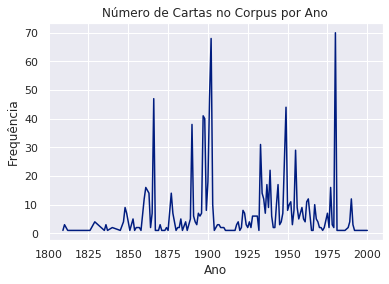

In [17]:
ax = sns.lineplot(x='Ano', y='Frequência', data=freq)
ax.set_title('Número de Cartas no Corpus por Ano')
plt.show()

O gráfico acima mostra diferenças substanciais no número de documentos por ano. Além disso, na maior parte dos anos, a frequência é inferior a 30 documentos. Antevendo a necessidade de treinamento dos modelos usados nas análises posteriores, decidimos avaliar possibilidades de agregação por intervalo de tempo (ex., 10 em 10 anos, 20 em 20, etc.). Os resultados para algumas alternativas são apresentados nos próximos gráficos.

In [18]:
def bar_periodo(dados, inicio=1823, periodo=10, fim=2000):
    freq_dic = dict()
    freq_dic[inicio] = freq.loc[[ano <= inicio \
                                 if not pd.isnull(ano) else False \
                                 for ano in freq.Ano]]['Frequência'].sum()
    for decada in range(inicio, fim, periodo):
        limite = decada + periodo if decada + periodo < fim else 2000
        freq_dic[limite] = freq.loc[[(ano > decada and ano <= limite) \
                                               if not pd.isnull(ano) else False \
                                               for ano in freq.Ano]]['Frequência'].sum()
    freq_periodo = pd.DataFrame(columns=['Ano', 'Frequência'])
    freq_periodo.Ano = freq_dic.keys()
    freq_periodo.Frequência = freq_dic.values()
    ax = sns.barplot(x='Ano', y='Frequência', data=freq_periodo)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title('Número de Cartas por Período')
    plt.show()

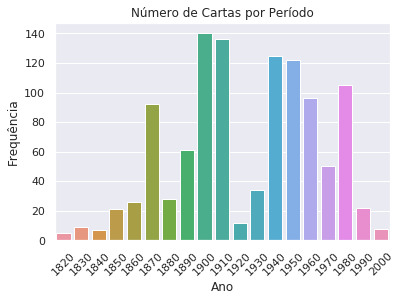

In [19]:
bar_periodo(freq, 1820, 10, 2000)

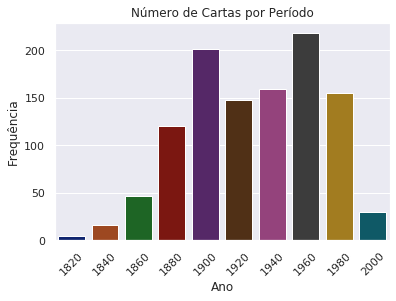

In [20]:
bar_periodo(freq, 1820, 20, 2000)

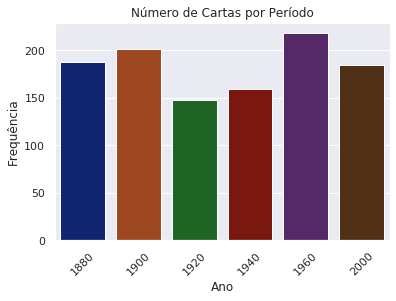

In [21]:
bar_periodo(freq, 1880, 20, 1980)

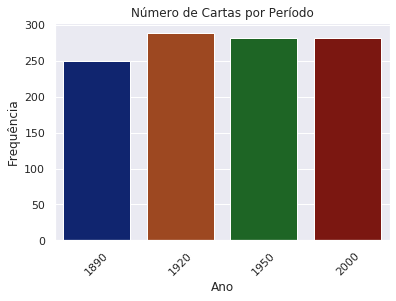

In [22]:
bar_periodo(freq, 1890, 30, 1980)

A opção de agrupamento acima é bem equilibrada em termos de número de documentos por período (entre 250 e 300 cartas). Além disso, inclui um número de faixas suficiente para representar períodos importantes da história brasileira:

  - **1823-1890**: Império
  - **1890-1920**: início da República
  - **1920-1950**: era Vargas, Segunda Grande Guerra, Juscelino Kubitschek
  - **1950-2000**: ditadura e democratização
  
Esses períodos foram adotados na análise longitudinal de tópicos e significados, descrita posteriormente.

### Remetentes e destinatários

Os metadados coletados incluem informações do remetente e do destinatário de uma carta. Verificamos que o número de remetentes únicos é bastante superior ao de destinatários. Além disso, ambos representam percentuais relativamente baixos do total de cartas do corpus. Logo, há mais de uma carta de um mesmo remetente, e várias cartas para um mesmo destinatário.

In [23]:
remetentes = len(metadados.Remetente.unique())
destinatarios = len(metadados.Destinatário.unique())
n_cartas = metadados.shape[0]

printmd('**Número de remetentes únicos no corpus: <font color="gray">' + 
        str(remetentes) + ' (' + str(round(100*remetentes/n_cartas, 2)) + '%)</font>**')
printmd('**Número de destinatários únicos no corpus: <font color="gray">' + 
        str(destinatarios) + ' (' + 
        str(round(100*destinatarios/n_cartas, 2)) + '%)</font>**')

**Número de remetentes únicos no corpus: <font color="gray">555 (46.84%)</font>**

**Número de destinatários únicos no corpus: <font color="gray">234 (19.75%)</font>**

O histograma do número de cartas de cada remetente indica que a vasta maioria dos remetentes escreveu menos de 10 cartas. Em torno de 3.2% dos remententes no corpus foram autores de mais de 10 documentos.

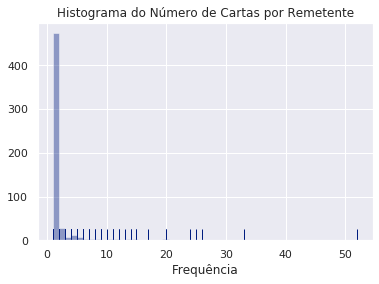

In [24]:
freq_rem = pd.DataFrame(Counter(metadados.Remetente).items(), 
                        columns=['Remetente', 'Frequência'])\
             .sort_values(by=['Frequência'], ascending=False)

ax = sns.distplot(freq_rem.Frequência, kde=False, rug=True)
ax.set_title('Histograma do Número de Cartas por Remetente')
plt.show()

In [25]:
n_rem = len(freq_rem.loc[freq_rem.Frequência > 10])

printmd('**Número de remetentes com mais de 10 cartas no corpus: <font color="gray">' + 
        str(n_rem) + ' (' + str(round(100*n_rem/remetentes, 2)) + '%)</font>**')

**Número de remetentes com mais de 10 cartas no corpus: <font color="gray">18 (3.24%)</font>**

In [26]:
printmd('<br/>**Remetentes de mais de 10 cartas:**')
freq_rem.loc[freq_rem.Frequência > 10]

<br/>**Remetentes de mais de 10 cartas:**

Remetente  Frequência
266  Aracy Leonardo Pereira                              52        
8    João Pinto Leite                                    33        
2    Antonio Fortunato da Silva                          26        
5    Antonia Thereza Wanderley                           25        
144  Benicio Penalva de Faria (B. Penalva)               24        
262  Francisco Mendes da Rocha                           20        
0    Arnaldo Andrade Dias (apócrifo)                     20        
41   F. Octaviano [Francisco Octaviano de Almeida Rosa]  17        
11   Renée da Silva Barros Soledade                      15        
17   Otto Soledade Júnior                                15        
95   Ângela Margarida Mesquita                           14        
111  B. de Cotegipe [João Mauricio Wanderley]            14        
407  Marcelino Pereira de Miranda                        13        
231  Renato Reis Galvão                                  12        
6    Carlos Ribeiro Freire                               12        
457  Regina Célia Siqueira dos Santos                    11        
527  Maria Luiza Wanderley de Araújo Pinho               11        
417  Quintino José Galo                                  11

Da mesma forma, vemos que poucas pessoas foram destinatárias de mais de 10 cartas. 

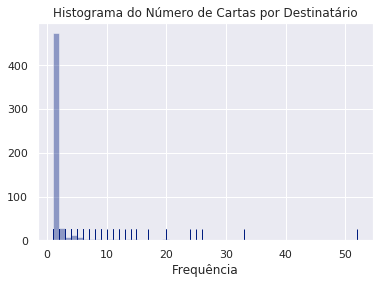

In [27]:
freq_dest = pd.DataFrame(Counter(metadados.Remetente).items(), 
                        columns=['Destinatário', 'Frequência'])\
             .sort_values(by=['Frequência'], ascending=False)

ax = sns.distplot(freq_dest.Frequência, kde=False, rug=True)
ax.set_title('Histograma do Número de Cartas por Destinatário')
plt.show()

In [28]:
n_dest = len(freq_dest.loc[freq_dest.Frequência > 10])

printmd('**Número de destinatários com mais de 10 cartas no corpus: <font color="gray">' + 
        str(n_dest) + ' (' + 
        str(round(100*n_dest/destinatarios, 2)) + '%)</font>**')

**Número de destinatários com mais de 10 cartas no corpus: <font color="gray">18 (7.69%)</font>**

In [29]:
printmd('<br/>**Destinatários de mais de 10 cartas:**')
freq_dest.loc[freq_dest.Frequência > 10]

<br/>**Destinatários de mais de 10 cartas:**

Destinatário  Frequência
266  Aracy Leonardo Pereira                              52        
8    João Pinto Leite                                    33        
2    Antonio Fortunato da Silva                          26        
5    Antonia Thereza Wanderley                           25        
144  Benicio Penalva de Faria (B. Penalva)               24        
262  Francisco Mendes da Rocha                           20        
0    Arnaldo Andrade Dias (apócrifo)                     20        
41   F. Octaviano [Francisco Octaviano de Almeida Rosa]  17        
11   Renée da Silva Barros Soledade                      15        
17   Otto Soledade Júnior                                15        
95   Ângela Margarida Mesquita                           14        
111  B. de Cotegipe [João Mauricio Wanderley]            14        
407  Marcelino Pereira de Miranda                        13        
231  Renato Reis Galvão                                  12        
6    Carlos Ribeiro Freire                               12        
457  Regina Célia Siqueira dos Santos                    11        
527  Maria Luiza Wanderley de Araújo Pinho               11        
417  Quintino José Galo                                  11

## Modelagem de tópicos

Para a modelagem de tópicos do corpus, utilizamos o algoritmo de Indexação Semântica Latente [(Latent Semantic Indexing - LSI)](https://en.wikipedia.org/wiki/Latent_semantic_analysis) da biblioteca [gensim](https://radimrehurek.com/gensim/). 

Inicialmente, mantivemos os textos das cartas originais sem alterações. Após os tokenizarmos, retendo a capitalização original e os *stop words*, criamos um modelo LSI com os 100 maiores autovalores na transformação SVD (*num_topics*) implementada no algoritmo. De acordo com [Bradford (2008)](https://doi.org/10.1145/1458082.1458105), para um corpus com milhões de documentos, valores entre 300 e 500 tendem a gerar resultados satisfatórios, enquanto valores entre 70 e 100 podem ser mais adequados para corpora menores ([Dumais, 1991](https://link.springer.com/content/pdf/10.3758/BF03203370.pdf).

Em seguida, repetimos a análise usando textos tokenizados, sem *stop words*, sem nomes próprios, em minúsculas, e lematizados. Para isso, usamos os seguintes procedimentos: 
  - A tokenização foi feita com a biblioteca [spaCy](https://spacy.io/usage/linguistic-features#tokenization). 
  - A deleção de *stop words* foi feita com base numa lista obtida da união das palavras disponíveis nas biblotecas [spaCy](https://spacy.io/usage/spacy-101) e [nltk](http://www.nltk.org/), complementada com pronomes pessoais, possessivos e de tratamento (ex., Excelentíssimo, Vossa Excelência, etc.), artigos indefinidos, alguns advérbios, e com as palavras da lista capitalizadas. Tokens com apenas um caracter foram descartados.
  - Há poucas alternaticas para implementar a lematização na língua portuguesa, todas com performance ainda abaixo das opções para a língua inglesa (https://lars76.github.io/nlp/lemmatize-portuguese/). Optamos por realizar a lematização com a biblioteca spaCy (https://spacy.io/api/lemmatizer).
  - A remoção de nomes próprios foi feita com auxílio da funcionalidade [*part-of-speach tagging*](https://spacy.io/usage/linguistic-features) da biblioteca spaCy. 

Como feito antes, para otimizar o uso da memória, criamos uma classe que implementa um iterador. Quando objeto da classe é iterado, o arquivo referente a uma carta do corpus é lido, e seu conteúdo é tokenizado e alimentado ao corpus e ao dicionário do gensim. O corpus utiliza o modelo [bag of words](https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html). 

A implementação da classe permite que, na criação do iterador, se defina se os *stop words* e nomes próprios serão removidos, se haverá lematização, e se os tokens serão passados para minúsculas. Tokens com apenas um caracter são removidos.

**Criação do conjunto de *stop words*:**

In [30]:
spacy_stopwords = spacy.lang.pt.stop_words.STOP_WORDS
printmd('**Número de *stop words* em português no spaCy: <font color="gray">' + str(len(spacy_stopwords)) + 
        '</font>**')
printmd('**Primeiros *stop words* na lista:**')
print(sorted(list(spacy_stopwords))[:20])

**Número de *stop words* em português no spaCy: <font color="gray">413</font>**

**Primeiros *stop words* na lista:**

['acerca', 'ademais', 'adeus', 'agora', 'ainda', 'algo', 'algumas', 'alguns', 'ali', 'além', 'ambas', 'ambos', 'antes', 'ao', 'aos', 'apenas', 'apoia', 'apoio', 'apontar', 'após']


In [31]:
nltk_stopwords = sorted(nltk.corpus.stopwords.words('portuguese'))
printmd('**Número de *stop words* em português no nlkt: <font color="gray">' + str(len(nltk_stopwords)) + 
        '</font>**')
printmd('**Primeiros *stop words* na lista:**')
print(nltk_stopwords[:20])

**Número de *stop words* em português no nlkt: <font color="gray">204</font>**

**Primeiros *stop words* na lista:**

['a', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois']


In [32]:
adicionais = {'você', 'vosmecê', 'porém', 'todavia', 'contudo', 'entretanto', 'entanto', 'logo', 'pois',
              'assim', 'conseguinte', 'nem', 'também', 'obstante', 'talvez', 'logo', 'pois', 'portanto',
              'isso', 'aquilo', 'aquiloutro', 'porquanto', 'senão', 'pelo', 'pelos', 'pela', 'pelas', 'dr', 'dra', 'sr', 'sra', 'srta', 
              'doutor', 'doutora', 'senhor', 'senhora', 'senhorita', 'v', 'sa', 'vossa', 'senhoria', 
              'exa', 'excelência', 'ema', 'eminência', 's', 'santidade', 'rev', 'reverendíssima', 
              'alteza', 'm', 'majestade', 'magnificência', 'excelentíssimo', 'excelentíssima', 
              'excelentíssimos', 'excelentíssimas', 'ilustríssimo', 'ilustríssimos', 'ilustríssima',
              'ilustríssimas', 'compadre', 'comadre', 'prezado', 'prezada', 'compadres', 
              'comadres', 'prezados', 'prezadas', 'mim', 'comigo', 'ti', 'contigo', 'ele', 'ela', 'si',
              'consigo', 'nós', 'conosco', 'vós', 'convosco', 'eles', 'elas', 'si', 'consigo', 
              'me', 'te', 'o', 'a', 'se', 'lhe', 'lha', 'lho', 'nos', 'vos', 'os', 'as', 'se', 'lhes', 
              'lhos', 'lhas', 'lo', 'los', 'la', 'los', 'no', 'nos', 'na' , 'nas', 'meu', 'minha', 
              'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'seu', 'sua', 'seus', 'suas', 
              'nosso', 'nossa', 'nossos', 'nossos', 'vosso', 'vossa', 'vossos', 'vossas', 'um', 'uns', 'uma',
              'umas', 'muito', 'muita', 'muitos', 'muitas', 'pouco', 'poucos', 'pouca', 'poucas', 'mesmo',
              'mesmos', 'mesmo', 'mesmas'}

adicionais = adicionais.union([x.capitalize() for x in list(adicionais)])

stopwords = set(spacy_stopwords).union(nltk_stopwords)

stopwords = stopwords\
              .union([word.capitalize() for word in list(stopwords)])\
              .union(adicionais)

stopwords = list(stopwords)

printmd('**Número de *stop words* nas duas bibliotecas: <font color="gray">' + str(len(stopwords)) + 
        '</font>**')
printmd('**Primeiros *stop words* na lista:**')
print(sorted(stopwords)[:50])

with open('stopwords.txt', 'w+') as file:
    file.writelines("%s\n" % word for word in sorted(stopwords))

**Número de *stop words* nas duas bibliotecas: <font color="gray">1138</font>**

**Primeiros *stop words* na lista:**

['A', 'Acerca', 'Ademais', 'Adeus', 'Agora', 'Ainda', 'Algo', 'Algumas', 'Alguns', 'Ali', 'Alteza', 'Além', 'Ambas', 'Ambos', 'Antes', 'Ao', 'Aos', 'Apenas', 'Apoia', 'Apoio', 'Apontar', 'Após', 'Aquela', 'Aquelas', 'Aquele', 'Aqueles', 'Aqui', 'Aquilo', 'Aquiloutro', 'As', 'Assim', 'Através', 'Atrás', 'Até', 'Aí', 'Baixo', 'Bastante', 'Bem', 'Boa', 'Bom', 'Breve', 'Cada', 'Caminho', 'Catorze', 'Cedo', 'Cento', 'Certamente', 'Certeza', 'Cima', 'Cinco']


**Definição da classe para a criação de corpus no gemsin:**

In [33]:
class GensimCorpus:
    def __init__(self, pasta, IDs, sufixo, dicionario, stop_words, 
                 lower=True, lema=False, nomes=False, num=False):
        self.pasta = pasta
        self.IDs = IDs
        self.sufixo = sufixo
        self.dicionario = dicionario
        self.stop = stop_words
        self.lower = lower
        self.lema = lema
        self.nomes = nomes
        self.num = num

    def __iter__(self):
        for id in self.IDs:
            fileid = self.pasta + id + self.sufixo
            
            with open(fileid, mode="r", encoding="utf-8") as doc:
                texto = doc.read()
                
            texto = nlp(texto)

            if self.nomes and not self.lema:
                tokens = [token.orth_ for token in texto if token.pos_ != 'PROPN']
            elif self.lema and not self.nomes:
                tokens = [token.lemma_ for token in texto]
            elif self.nomes and self.lema:
                tokens = [token.lemma_ for token in texto if token.pos_ != 'PROPN']
            else:
                tokens = [token.orth_ for token in texto]

            if self.lower:
                tokens = [token.lower() for token in tokens]
            
            tokens = [token for token in tokens 
                      if token not in self.stop and len(token) > 1]
            
            if self.num:
                tokens = [re.sub('[$:0-9]*', '', token) 
                          for token in tokens]
                tokens = [token for token in tokens if len(token) > 1]
                
            self.dicionario.add_documents([tokens])

            yield self.dicionario.doc2bow(tokens)

In [34]:
if not os.path.exists('Modelos/'):   # se necessário, cria pasta para corpora dos modelos
    os.makedirs('Modelos/')

### Resultados com mínimo pré-processamento dos textos

Na primeira análise, criamos o corpus do gensim com os textos tokenizados, sem a exclusão de *stop words* e nomes próprios, lematização, ou passagem dos tokens para minúsculas.

In [35]:
dic_gensim = corpora.Dictionary()

corpus_gensim = GensimCorpus('CE-DOHS-proc/', metadados.ID , '-proc.txt', dic_gensim, [],
                             lower=False, lema=False, nomes=False, num=False)

Como sugerido no [tutorial do gensim](https://radimrehurek.com/gensim//auto_examples/core/run_topics_and_transformations.html), a transformação LSI recebeu como entrada o resultado da transformação do corpus para o espaço tf-idf.

In [36]:
if os.path.exists('Modelos/modelo_tfidf_min.md') and \
   os.path.exists('Modelos/corpus_tfidf_min.cp'):
    modelo_tfidf = TfidfModel.load('Modelos/modelo_tfidf_min.md')    # carrega o modelo tf-idf
    corpus_tfidf = MmCorpus('Modelos/corpus_tfidf_min.cp')           # carrega o corpus tf-idf
else:
    modelo_tfidf = TfidfModel(corpus_gensim, normalize=True)         # inicialização da trasnformação tf-idf
    corpus_tfidf = modelo_tfidf[corpus_gensim]                       # transformação do corpus
    modelo_tfidf.save('Modelos/modelo_tfidf_min.md')                 # salva o modelo tf-idf
    MmCorpus.serialize('Modelos/corpus_tfidf_min.cp', corpus_tfidf)  # salva o corpus tf-idf

O modelo LSI foi criado com o corpus transformado para o espaço tf-idf.

In [37]:
if os.path.exists('Modelos/modelo_lsi_min_100.md') and \
   os.path.exists('Modelos/corpus_lsi_min_100.cp'):
    modelo_lsi = LsiModel.load('Modelos/modelo_lsi_min_100.md')
    corpus_lsi = MmCorpus('Modelos/corpus_lsi_min_100.cp')
else:
    modelo_lsi = LsiModel(corpus_tfidf, id2word=dic_gensim, num_topics=100)
    corpus_lsi = modelo_lsi[corpus_tfidf]    
    modelo_lsi.save('Modelos/modelo_lsi_min_100.md')
    MmCorpus.serialize('Modelos/corpus_lsi_min_100.cp', corpus_lsi)

O primeiro tópico, com os pesos dos primeiros 100 tokens, é mostrado abaixo. 

In [38]:
printmd('**100 primeiras palavras do primeiro tópico identificado:**')
pprint(modelo_lsi.print_topics(num_topics=1, num_words=100)[0][1])

**100 primeiras palavras do primeiro tópico identificado:**

('0.160*"Vossa" + 0.156*"Excelência" + 0.150*"você" + 0.136*"eu" + 0.091*"ele" '
 '+ 0.089*"compadre" + 0.088*"me" + 0.085*"não" + 0.080*"minha" + 0.079*"lhe" '
 '+ 0.078*"meu" + 0.077*"os" + 0.077*"por" + 0.074*"dia" + 0.074*"amigo" + '
 '0.073*"um" + 0.073*"mas" + 0.073*"aqui" + 0.073*"as" + 0.072*"no" + '
 '0.072*"em" + 0.071*"te" + 0.071*"muito" + 0.071*"Deus" + 0.071*"mais" + '
 '0.071*"se" + 0.070*"bem" + 0.070*"sua" + 0.070*"uma" + 0.070*"pois" + '
 '0.069*"está" + 0.069*"como" + 0.068*"seu" + 0.068*"já" + 0.068*"tem" + '
 '0.067*"foi" + 0.066*"senhor" + 0.066*"Dr" + 0.066*"todos" + 0.065*"mim" + '
 '0.065*"esta" + 0.065*"na" + 0.065*"tenho" + 0.064*"vou" + 0.063*"vai" + '
 '0.063*"João" + 0.062*"carta" + 0.061*"este" + 0.061*"Senhor" + 0.061*"estou" '
 '+ 0.060*"ela" + 0.060*"só" + 0.060*"dos" + 0.059*"mesmo" + 0.059*"ou" + '
 '0.058*"tudo" + 0.058*"porque" + 0.058*"ser" + 0.057*"do" + 0.057*"da" + '
 '0.056*"pelo" + 0.056*"quando" + 0.056*"com" + 0.055*"fazer" + 0.055*"aí" + '

Para facilitar a visualização e análise dos resultados, geramos os primeiros 50 tokens dos cinco tópicos iniciais, sem os seus respectivos pesos.

In [39]:
palavras = []

for i in range(50):
    palavras.append([word for (word, load) in modelo_lsi.show_topic(i, 100) if len(word) > 1])
    if i < 5:
        printmd('**Tópico ' + str(i+1) + ':**')
        print(palavras[i][:50])

**Tópico 1:**

['Vossa', 'Excelência', 'você', 'eu', 'ele', 'compadre', 'me', 'não', 'minha', 'lhe', 'meu', 'os', 'por', 'dia', 'amigo', 'um', 'mas', 'aqui', 'as', 'no', 'em', 'te', 'muito', 'Deus', 'mais', 'se', 'bem', 'sua', 'uma', 'pois', 'está', 'como', 'seu', 'já', 'tem', 'foi', 'senhor', 'Dr', 'todos', 'mim', 'esta', 'na', 'tenho', 'vou', 'vai', 'João', 'carta', 'este', 'Senhor', 'estou']


**Tópico 2:**

['Vossa', 'Excelência', 'você', 'eu', 'te', 'Senhoria', 'Pitanga', 'compadre', 'Carneiro', 'Adelmário', 'vou', 'lembrança', 'Excelentíssimo', 'comadre', 'mim', 'estou', 'Senhor', 'Deus', 'vai', 'Excelentíssima', 'Valente', 'De', 'senhora', 'Fortunato', 'Dr', 'Oliveira', 'Zenilta', 'Senhora', 'saudade', 'Amigo', 'amor', 'Almerinda', 'Maro', 'sim', 'mas', 'Ilustríssimo', 'criado', 'amigo', 'saber', 'respeito', 'Você', 'todos', 'Barão', 'porque', 'beijo', 'mande', 'Doutor', 'consideração', 'Conselheiro', 'doutor']


**Tópico 3:**

['compadre', 'Pitanga', 'senhor', 'você', 'Fortunato', 'comadre', 'lembrança', 'Almerinda', 'Silva', 'sim', 'eu', 'Antonio', 'senhora', 'Adelmário', 'mando', 'prezado', 'Saudação', 'notícia', 'mim', 'Você', 'Vossa', 'Oliveira', 'Excelência', 'te', 'Compadre', 'Paulo', 'linha', 'Valente', 'Deus', 'bote', 'Maro', 'mande', 'querido', 'vire', 'benção', 'Fazenda', 'menino', 'saber', 'vou', '63', 'qui', 'Rua', 'estimado', '62', 'Escrito', 'nada', 'Regina', 'Comadre', 'minha', 'Riachão']


**Tópico 4:**

['Vossa', 'Excelência', 'você', 'Adelmário', 'Senhoria', 'eu', 'te', 'Valente', 'compadre', 'Primo', 'Carneiro', 'Maro', 'Rua', 'Doutor', 'Dr', 'ele', 'Regina', '48890', 'ontem', 'amor', 'Araújo', 'aqui', 'amigo', 'Calixto', 'Ilustríssimo', 'Compadre', 'Dantas', '69', 'os', 'Senhora', 'amigos', 'De', 'Para', 'visitas', 'Santo', 'eleição', 'CEP', '80', 'estão', 'nossos', 'Prezado', 'estou', 'Querido', 'Espero', '1980', 'Olha', 'Zenilta', 'Você', 'dia', 'foi']


**Tópico 5:**

['te', 'compadre', 'Senhora', 'amigo', 'Adelmário', 'Vossa', 'Maria', 'ela', 'Excelência', 'Você', 'eu', 'Amaro', 'Zenilta', 'senhor', 'Comadre', 'Dantas', 'Aracy', 'casa', 'Celina', 'Amigo', 'senhora', 'Santo', 'você', 'mas', 'Madrinha', 'Leite', 'Minha', 'Madre', 'ir', 'lá', 'Rua', '00', 'Prezado', 'meu', 'abraços', 'Junior', 'papel', 'Regina', 'Abbadeça', 'Valente', 'ontem', 'lembranças', 'nosso', 'Jovina', 'Meu', 'Dona', 'Senhor', 'Antonia', '48890', 'Oliveira']


In [40]:
n_topicos = set(range(5))
for i in list(n_topicos):
    outros = n_topicos - set([i])
    set_outros = set()
    for j in outros:
        set_outros = set_outros.union(palavras[j][:50])
    printmd('**Tokens apenas no tópico ' + str(i+1) + ':**')
    print(set(palavras[i][:50]) - set_outros)

**Tokens apenas no tópico 1:**

{'mais', 'carta', 'não', 'me', 'João', 'tenho', 'tem', 'no', 'muito', 'as', 'bem', 'na', 'sua', 'lhe', 'uma', 'está', 'um', 'esta', 'já', 'pois', 'em', 'se', 'seu', 'este', 'como', 'por'}


**Tokens apenas no tópico 2:**

{'criado', 'saudade', 'porque', 'Excelentíssima', 'Barão', 'Conselheiro', 'respeito', 'doutor', 'consideração', 'Excelentíssimo', 'beijo'}


**Tokens apenas no tópico 3:**

{'qui', 'Silva', 'Riachão', 'Fazenda', 'bote', 'estimado', 'Antonio', 'prezado', 'notícia', 'benção', 'Paulo', 'menino', 'Escrito', '62', 'vire', 'Saudação', 'querido', 'linha', '63', 'nada', 'mando'}


**Tokens apenas no tópico 4:**

{'estão', '80', 'CEP', 'Querido', 'visitas', 'Araújo', 'nossos', 'Calixto', 'eleição', 'amigos', 'Para', 'Olha', 'Espero', '1980', 'Primo', '69'}


**Tokens apenas no tópico 5:**

{'Jovina', 'Minha', 'Dona', 'abraços', 'lá', 'Aracy', 'Abbadeça', 'ela', 'casa', 'papel', 'nosso', 'Madrinha', 'Antonia', 'Leite', '00', 'Amaro', 'Celina', 'lembranças', 'ir', 'Meu', 'Junior', 'Madre', 'Maria'}


O conjunto das 100 palavras mais importantes de cada um dos 50 primeiros tópicos foi usado para criar a nuvem de palavras exibida abaixo.

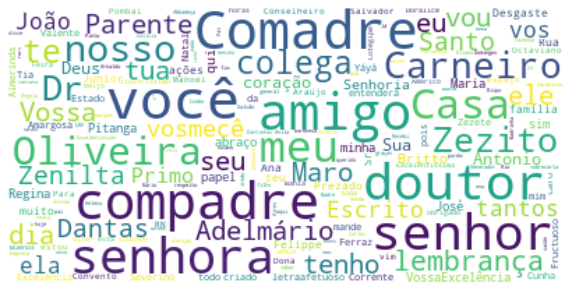

In [41]:
todas = palavras[0]

for i in range(1,50):
    todas.extend(palavras[i])

nuvem = ' '.join(todas)

# Gera a nuvem de palavras
wordcloud = WordCloud().generate(nuvem)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",
                      max_words=len(todas),
                      max_font_size=40, 
                      relative_scaling=.6) \
            .generate(nuvem)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

De forma geral, os tópicos obtidos são pouco informativos. Em todos, prevalecem nomes próprios, números e pronomes, além de haver verbos flexionados e palavras que aparecem capitalizadas e em minúsculas, dificultando a interpretação dos resultados.

### Resultados com remoção de *stop words*, nomes próprios e números

Os passos anteriores foram repetidos, adicionando-se, na criação do corpus do gensim, as opções de remoção de *stop words*, nomes próprios e números, e passagem dos tokens para minúsculas.

In [42]:
dic_gensim = corpora.Dictionary()
corpus_gensim = GensimCorpus('CE-DOHS-proc/', metadados.ID, '-proc.txt', dic_gensim, stopwords,
                             lower=True, lema=False, nomes=True, num=True)

if os.path.exists('Modelos/modelo_tfidf_rm.md') and \
   os.path.exists('Modelos/corpus_tfidf_rm.cp'):
    modelo_tfidf = TfidfModel.load('Modelos/modelo_tfidf_rm.md')     # carrega o modelo tf-idf
    corpus_tfidf = MmCorpus('Modelos/corpus_tfidf_rm.cp')            # carrega o corpus tf-idf
else:
    modelo_tfidf = models.TfidfModel(corpus_gensim, normalize=True)  # inicialização da trasnformação tf-idf
    corpus_tfidf = modelo_tfidf[corpus_gensim]                       # transformação do corpus
    modelo_tfidf.save('Modelos/modelo_tfidf_rm.md')                  # salve o modelo tf-idf
    MmCorpus.serialize('Modelos/corpus_tfidf_rm.cp', corpus_tfidf)   # salva o corpus tf-idf

if os.path.exists('Modelos/modelo_lsi_100_rm.md') and \
   os.path.exists('Modelos/corpus_lsi_100_rm.cp'):
    modelo_lsi = LsiModel.load('Modelos/modelo_lsi_100_rm.md')       # carrega o modelo lsi
    corpus_lsi = MmCorpus('Modelos/corpus_lsi_100_rm.cp')            # carrega o corpus lsi
else:
    modelo_lsi = models.LsiModel(corpus_tfidf, id2word=dic_gensim, num_topics=100)   # inicialização
    corpus_lsi = modelo_lsi[corpus_tfidf]                                            # transformação do corpus
    modelo_lsi.save('Modelos/modelo_lsi_100_rm.md')                                  # salva o modelo lsi
    MmCorpus.serialize('Modelos/corpus_lsi_100_rm.cp', corpus_lsi)                      # salva o corpus lsi

In [43]:
printmd('**100 primeiras palavras do primeiro tópico identificado:**')
pprint(modelo_lsi.print_topics(num_topics=1, num_words=100)[0][1])

**100 primeiras palavras do primeiro tópico identificado:**

('-0.142*"vou" + -0.138*"dia" + -0.133*"amigo" + -0.117*"carta" + '
 '-0.115*"lembrança" + -0.107*"saúde" + -0.107*"hoje" + -0.105*"casa" + '
 '-0.089*"disse" + -0.087*"abraço" + -0.086*"dias" + -0.085*"família" + '
 '-0.085*"desejo" + -0.084*"recebi" + -0.079*"mande" + -0.079*"melhor" + '
 '-0.074*"amigos" + -0.074*"notícia" + -0.074*"graças" + -0.073*"vida" + '
 '-0.073*"manda" + -0.073*"espero" + -0.070*"coração" + -0.069*"bahia" + '
 '-0.069*"notícias" + -0.066*"dinheiro" + -0.066*"dê" + -0.066*"mandar" + '
 '-0.065*"querido" + -0.064*"saudade" + -0.063*"lembranças" + '
 '-0.063*"resposta" + -0.063*"escrever" + -0.062*"peço" + -0.061*"certo" + '
 '-0.061*"fiquei" + -0.061*"paz" + -0.061*"amor" + -0.061*"respeito" + '
 '-0.060*"mando" + -0.060*"caso" + -0.060*"ano" + -0.059*"alguma" + '
 '-0.058*"felicidade" + -0.058*"linha" + -0.058*"ordens" + -0.057*"amiga" + '
 '-0.057*"veio" + -0.056*"papel" + -0.056*"outro" + -0.056*"cartas" + '
 '-0.056*"prazer" + -0.056*"deu" + -0.055*"amanhã

Para facilitar a visualização dos resultados, mostramos abaixo os primeiros 50 tokens dos cinco tópicos iniciais, sem os seus respectivos pesos.

In [44]:
palavras = []

for i in range(50):
    palavras.append([word for (word, load) in modelo_lsi.show_topic(i, 100) if len(word) > 1])
    if i < 5:
        printmd('**Tópico ' + str(i+1) + ':**')
        print(palavras[i][:50])

**Tópico 1:**

['vou', 'dia', 'amigo', 'carta', 'lembrança', 'saúde', 'hoje', 'casa', 'disse', 'abraço', 'dias', 'família', 'desejo', 'recebi', 'mande', 'melhor', 'amigos', 'notícia', 'graças', 'vida', 'manda', 'espero', 'coração', 'bahia', 'notícias', 'dinheiro', 'dê', 'mandar', 'querido', 'saudade', 'lembranças', 'resposta', 'escrever', 'peço', 'certo', 'fiquei', 'paz', 'amor', 'respeito', 'mando', 'caso', 'ano', 'alguma', 'felicidade', 'linha', 'ordens', 'amiga', 'veio', 'papel', 'outro']


**Tópico 2:**

['lembrança', 'vou', 'mando', 'saudação', 'manda', 'saudade', 'notícia', 'mande', 'linha', 'amigo', 'querido', 'benção', 'qui', 'margem', 'papel', 'vire', 'graças', 'bote', 'menino', 'dê', 'vim', 'querida', 'amor', 'deus', 'felicidade', 'dinheiro', 'pitanga', 'estimado', 'quizer', 'olhe', 'beijo', 'escreva', 'terminar', 'fiquei', 'pedido', 'linhas', 'pego', 'dona', 'respeito', 'vida', 'amiga', 'tendo', 'ordens', 'votos', 'colega', 'nomeação', 'criado', 'barão', 'casa', 'consideração']


**Tópico 3:**

['lembrança', 'amigo', 'lembranças', 'notícia', 'dia', 'mando', 'abraços', 'saudação', 'disse', 'linha', 'hoje', 'dias', 'saudades', 'veio', 'estima', 'colega', 'saúde', 'criado', 'estimado', 'consideração', 'amanhã', 'nomeação', 'noite', 'semana', 'pitanga', 'casa', 'peço', 'dê', 'votos', 'amigos', 'benção', 'beija', 'parente', 'mandou', 'pedido', 'bote', 'sábado', 'gostei', 'feira', 'família', 'vire', 'provas', 'espaço', 'passar', 'bahia', 'outubro', 'serviço', 'felizmente', 'receber', 'qui']


**Tópico 4:**

['amor', 'dinheiro', 'beijo', 'espero', 'casa', 'notícia', 'mando', 'feliz', 'mande', 'abraço', 'nº', 'lembrança', 'amo', 'paz', 'querido', 'saudade', 'endereço', 'colega', 'disse', 'vida', 'mandar', 'ano', 'certo', 'manda', 'felicidade', 'gostaria', 'impressão', 'bahia', 'amiga', 'menino', 'querida', 'amanhã', 'jovem', 'espaço', 'votos', 'hoje', 'negócio', 'legal', 'viver', 'pessoal', 'linha', 'veio', 'coração', 'fé', 'moto', 'cep', 'foto', 'sinto', 'ilegível', 'postal']


**Tópico 5:**

['herdeiros', 'resposta', 'respeito', 'pertence', 'querido', 'reis', 'abraço', 'negócio', 'pagar', 'quantia', 'espero', 'dia', 'juros', 'constança', 'receber', 'dinheiro', 'notícias', 'dívida', 'contas', 'visitas', 'quiser', 'custas', 'agita', 'agitar', 'precisões', 'julho', 'aceite', 'meninos', 'fl', 'principal', 'escreva', 'procuração', 'rogar', 'mando', 'conta', 'possa', 'mandar', 'mande', 'nº', 'setembro', 'horas', 'graças', 'antigo', 'ordens', 'saúde', 'lembrança', 'mesma', 'pleito', 'execução', 'ações']


In [45]:
n_topicos = set(range(5))

for i in list(n_topicos):
    outros = n_topicos - set([i])

    set_outros = set()

    for j in outros:
        set_outros = set_outros.union(palavras[j][:50])
    
    printmd('**Tokens apenas no tópico ' + str(i+1) + ':**')
    print(sorted(set(palavras[i][:50]) - set_outros))

**Tokens apenas no tópico 1:**

['alguma', 'carta', 'caso', 'desejo', 'escrever', 'melhor', 'outro', 'recebi']


**Tokens apenas no tópico 2:**

['barão', 'deus', 'dona', 'linhas', 'margem', 'olhe', 'pego', 'quizer', 'tendo', 'terminar', 'vim']


**Tokens apenas no tópico 3:**

['abraços', 'beija', 'estima', 'feira', 'felizmente', 'gostei', 'mandou', 'noite', 'outubro', 'parente', 'passar', 'provas', 'saudades', 'semana', 'serviço', 'sábado']


**Tokens apenas no tópico 4:**

['amo', 'cep', 'endereço', 'feliz', 'foto', 'fé', 'gostaria', 'ilegível', 'impressão', 'jovem', 'legal', 'moto', 'pessoal', 'postal', 'sinto', 'viver']


**Tokens apenas no tópico 5:**

['aceite', 'agita', 'agitar', 'antigo', 'ações', 'constança', 'conta', 'contas', 'custas', 'dívida', 'execução', 'fl', 'herdeiros', 'horas', 'julho', 'juros', 'meninos', 'mesma', 'pagar', 'pertence', 'pleito', 'possa', 'precisões', 'principal', 'procuração', 'quantia', 'quiser', 'reis', 'rogar', 'setembro', 'visitas']


O conjunto das 100 palavras mais importantes de cada um dos 50 primeiros tópicos foi usado para criar a nuvem de palavras exibida abaixo.

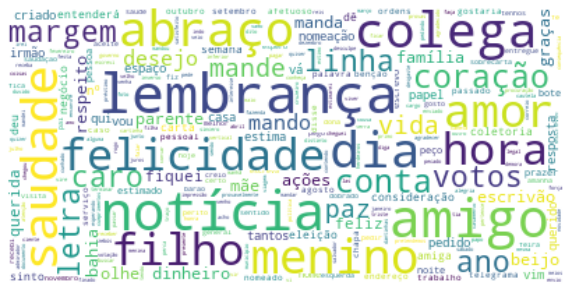

In [46]:
todas = palavras[0]

for i in range(1,50):
    todas.extend(palavras[i])

nuvem = ' '.join(todas)

# Gera a nuvem de palavras
wordcloud = WordCloud().generate(nuvem)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",
                      max_words=len(todas),
                      max_font_size=40, 
                      relative_scaling=.6) \
            .generate(nuvem)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

As primeiras 50 palavras dos tópicos gerados incluem diversas palavras em comum, grande parte delas refletindo termos tipicamente encontrados em cartas, como saudações e expressões de cunho afetivo. Embora sua ordenação seja razoavelmente distinta em cada tópico, refletindo diferenças em grau de importância na constituição do tópico, ela não permite diferenciar claramente os significados dos temas.

Apesar disso, pode-se notar uma aparente distinção entre os quatro primeiros tópicos e o quinto:

  - Nos <u>*quatro primeiros tópicos*</u>, predominam palavras tipicamente encontradas em mensagens pessoais entre sujeitos que mantêm algum relacionamento. Neles, há termos, como 'amigo', 'abraço', 'coração', 'querido', 'saudade', 'beijo', e 'amor'.
  - No <u>*quinto tópico*</u>, surgem palavras que podem estar associadas a relações mais formais. Há, inclusive, termos relativos a questões financeiras, como 'herdeiros', 'embolçar', 'quantia', 'dívida', 'juros', 'contas', 'dívida', 'custas'.

### Resultados com lematização

Nesta etapa, além da remoção de *stop words*, nomes próprios e números, e da passagem dos tokens para minúsculas, incluímos a lematização na criação do corpus do gensim.

In [47]:
dic_gensim = corpora.Dictionary()
corpus_gensim = GensimCorpus('CE-DOHS-proc/', metadados.ID, '-proc.txt', dic_gensim, stopwords,
                             lower=True, lema=True, nomes=True, num=True)

if os.path.exists('Modelos/modelo_tfidf_lem.md') and \
   os.path.exists('Modelos/corpus_tfidf_lem.cp'):
    modelo_tfidf = TfidfModel.load('Modelos/modelo_tfidf_lem.md')     # carrega o modelo tf-idf
    corpus_tfidf = MmCorpus('Modelos/corpus_tfidf_lem.cp')            # carrega o corpus tf-idf
else:
    modelo_tfidf = models.TfidfModel(corpus_gensim, normalize=True)   # inicialização da trasnformação tf-idf
    corpus_tfidf = modelo_tfidf[corpus_gensim]                        # transformação do corpus
    modelo_tfidf.save('Modelos/modelo_tfidf_lem.md')                  # salve o modelo tf-idf
    MmCorpus.serialize('Modelos/corpus_tfidf_lem.cp', corpus_tfidf)   # salva o corpus tf-idf

if os.path.exists('Modelos/modelo_lsi_100_lem.md') and \
   os.path.exists('Modelos/corpus_lsi_100_lem.cp'):
    modelo_lsi = LsiModel.load('Modelos/modelo_lsi_100_lem.md')       # carrega o modelo lsi
    corpus_lsi = MmCorpus('Modelos/corpus_lsi_100_lem.cp')            # carrega o corpus lsi
else:
    modelo_lsi = models.LsiModel(corpus_tfidf, id2word=dic_gensim, num_topics=100)    # inicialização
    corpus_lsi = modelo_lsi[corpus_tfidf]                                             # transformação do corpus
    modelo_lsi.save('Modelos/modelo_lsi_100_lem.md')                                  # salva o modelo lsi
    MmCorpus.serialize('Modelos/corpus_lsi_100_lem.cp', corpus_lsi)                   # salva o corpus lsi

In [48]:
printmd('**100 primeiras palavras do primeiro tópico identificado:**')
pprint(modelo_lsi.print_topics(num_topics=1, num_words=100)[0][1])

**100 primeiras palavras do primeiro tópico identificado:**

('0.154*"compadrar" + 0.139*"mandar" + 0.128*"dia" + 0.118*"amigar" + '
 '0.112*"suar" + 0.111*"querer" + 0.111*"umar" + 0.109*"cartar" + '
 '0.108*"comer" + 0.105*"vir" + 0.105*"escrever" + 0.105*"lembrança" + '
 '0.104*"ficar" + 0.102*"passar" + 0.101*"pelar" + 0.100*"receber" + '
 '0.099*"casar" + 0.097*"pedir" + 0.094*"haver" + 0.092*"hoje" + '
 '0.091*"saudar" + 0.090*"chegar" + 0.089*"nado" + 0.087*"outro" + '
 '0.086*"amigo" + 0.085*"parir" + 0.084*"notícia" + 0.082*"achar" + '
 '0.080*"algum" + 0.079*"dever" + 0.077*"abraçar" + 0.077*"menino" + '
 '0.076*"esperar" + 0.075*"estimar" + 0.073*"contar" + 0.073*"encontrar" + '
 '0.073*"desejar" + 0.072*"família" + 0.069*"melhor" + 0.068*"saudade" + '
 '0.066*"ano" + 0.066*"sentir" + 0.065*"responder" + 0.064*"continuar" + '
 '0.064*"sobrar" + 0.064*"ordem" + 0.063*"visitar" + 0.063*"deixar" + '
 '0.062*"filho" + 0.062*"linha" + 0.062*"falar" + 0.062*"sair" + 0.061*"vidar" '
 '+ 0.061*"seguir" + 0.060*"enviar" + 0.060*"caro" + 0.060*

Seguem os primeiros 50 tokens dos dez tópicos iniciais, sem os seus respectivos pesos.

In [49]:
palavras = []

for i in range(50):
    palavras.append([word for (word, load) in modelo_lsi.show_topic(i, 100) if len(word) > 1])
    if i < 5:
        printmd('**Tópico ' + str(i+1) + ':**')
        print(palavras[i][:50])

**Tópico 1:**

['compadrar', 'mandar', 'dia', 'amigar', 'suar', 'querer', 'umar', 'cartar', 'comer', 'vir', 'escrever', 'lembrança', 'ficar', 'passar', 'pelar', 'receber', 'casar', 'pedir', 'haver', 'hoje', 'saudar', 'chegar', 'nado', 'outro', 'amigo', 'parir', 'notícia', 'achar', 'algum', 'dever', 'abraçar', 'menino', 'esperar', 'estimar', 'contar', 'encontrar', 'desejar', 'família', 'melhor', 'saudade', 'ano', 'sentir', 'responder', 'continuar', 'sobrar', 'ordem', 'visitar', 'deixar', 'filho', 'linha']


**Tópico 2:**

['compadrar', 'lembrança', 'linha', 'mandar', 'menino', 'saudação', 'botar', 'prezar', 'notícia', 'benção', 'nado', 'margem', 'dinheiro', 'pitanga', 'ciraldo', 'virar', 'qui', 'esquecer', 'deus', 'graça', 'pelar', 'olhar', 'quizer', 'cruzeiro', 'escrever', 'dever', 'vertical', 'pedir', 'haver', 'saudade', 'sobrar', 'destá', 'algum', 'apresentar', 'amigar', 'vidar', 'político', 'querer', 'agradecer', 'nomear', 'consideração', 'papel', 'colega', 'respeitar', 'nomeação', 'agostar', 'dispor', 'criar', 'barão', 'obrigar']


**Tópico 3:**

['compadrar', 'amigar', 'querido', 'amor', 'gostar', 'saudade', 'beijar', 'lembrança', 'terminar', 'estimar', 'amar', 'dia', 'prezar', 'obrigar', 'menino', 'abraço', 'perguntar', 'nó', 'graça', 'recomendar', 'apresentar', 'criar', 'vir', 'serviço', 'ordem', 'nomeação', 'falar', 'nomear', 'consideração', 'papel', 'mandar', 'namorar', 'querer', 'pelar', 'foto', 'abraçar', 'passar', 'político', 'olhar', 'sentir', 'voto', 'comprar', 'ficar', 'telefonar', 'dispor', 'eleição', 'mãe', 'pedir', 'noite', 'tardar']


**Tópico 4:**

['felicidade', 'amor', 'pagar', 'querido', 'mandar', 'comprar', 'abraçar', 'amar', 'dinheiro', 'dia', 'desejar', 'compadrar', 'vidar', 'paz', 'nó', 'amigar', 'sincero', 'feliz', 'coração', 'lembrança', 'saudar', 'negócio', 'colega', 'amanhã', 'hoje', 'prazer', 'estimar', 'procuração', 'sair', 'linha', 'vir', 'contar', 'aceitar', 'voto', 'esquecer', 'haver', 'casar', 'semana', 'telefonar', 'rei', 'estevar', 'respeitar', 'margem', 'abraço', 'pé', 'saudação', 'fé', 'irar', 'pagamento', 'levar']


**Tópico 5:**

['compadrar', 'lembrança', 'gostar', 'espero', 'nº', 'saudar', 'conhecer', 'namorar', 'ano', 'foto', 'graça', 'falar', 'menino', 'linha', 'amor', 'estudar', 'aceitar', 'legal', 'endereçar', 'bahia', 'estimar', 'trabalhar', 'salvador', 'benção', 'fortaleza', 'moto', 'espaçar', 'dono', 'tio', 'estudo', 'vender', 'abraçar', 'deus', 'notícia', 'certar', 'fazenda', 'gozar', 'mandar', 'papel', 'conseguir', 'postal', 'adelmário', 'nome', 'maro', 'dobrar', 'paqueras', 'criar', 'afilhar', 'filho', 'amar']


In [50]:
n_topicos = set(range(5))

for i in list(n_topicos):
    outros = n_topicos - set([i])

    set_outros = set()

    for j in outros:
        set_outros = set_outros.union(palavras[j][:50])
    
    printmd('**Tokens apenas no tópico ' + str(i+1) + ':**')
    print(sorted(set(palavras[i][:50]) - set_outros))

**Tokens apenas no tópico 1:**

['achar', 'amigo', 'cartar', 'chegar', 'comer', 'continuar', 'deixar', 'encontrar', 'esperar', 'família', 'melhor', 'outro', 'parir', 'receber', 'responder', 'suar', 'umar', 'visitar']


**Tokens apenas no tópico 2:**

['agostar', 'agradecer', 'barão', 'botar', 'ciraldo', 'cruzeiro', 'destá', 'pitanga', 'qui', 'quizer', 'vertical', 'virar']


**Tokens apenas no tópico 3:**

['beijar', 'eleição', 'mãe', 'noite', 'perguntar', 'recomendar', 'serviço', 'tardar', 'terminar']


**Tokens apenas no tópico 4:**

['amanhã', 'coração', 'estevar', 'felicidade', 'feliz', 'fé', 'irar', 'levar', 'negócio', 'pagamento', 'pagar', 'paz', 'prazer', 'procuração', 'pé', 'rei', 'sair', 'semana', 'sincero']


**Tokens apenas no tópico 5:**

['adelmário', 'afilhar', 'bahia', 'certar', 'conhecer', 'conseguir', 'dobrar', 'dono', 'endereçar', 'espaçar', 'espero', 'estudar', 'estudo', 'fazenda', 'fortaleza', 'gozar', 'legal', 'maro', 'moto', 'nome', 'nº', 'paqueras', 'postal', 'salvador', 'tio', 'trabalhar', 'vender']


O conjunto das 100 palavras mais importantes de cada um dos 50 primeiros tópicos foi usado para criar a nuvem de palavras exibida abaixo.

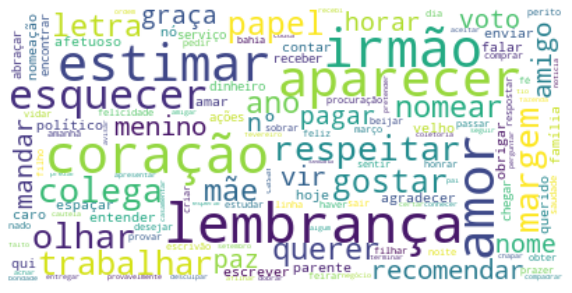

In [51]:
todas = palavras[0]

for i in range(1,50):
    todas.extend(palavras[i])

nuvem = ' '.join(todas)

# Gera a nuvem de palavras
wordcloud = WordCloud().generate(nuvem)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",
                      max_words=len(todas),
                      max_font_size=40, 
                      relative_scaling=.6) \
            .generate(nuvem)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

O modelo de lematização em português da biblioteca spaCy claramente apresenta problemas. Diversos substantivos parecem ter sido transformados em verbos incorretamente, como 'amiga' para 'amigar', 'carta' para 'cartar', 'casa' para 'casar', e 'beijo' para 'beijar'. Os resultados reportados em artigos e blogs confirmam essa limitação, que parece não ser não intensa para a língua inglesa (ex. https://lars76.github.io/nlp/lemmatize-portuguese/; https://towardsdatascience.com/state-of-the-art-multilingual-lemmatization-f303e8ff1a8).

Dado que a implementação da lematização gerou tópicos menos claros do que os obtidos anteriormente, o método não será utilizado nas análises seguintes. 

### Variações nos tópicos ao longo do tempo

Os quatro períodos definidos anteriormente (1823-1890, 1890-1920, 1920-1950 e 1950-2000) foram usados para dividir os textos em quatro corpora. Para cada um deles, repetimos a análise com o modelo LSI e a opção de remoção de *stop words* e nomes próprios, lematização, e passagem para minúsculas.

**Criação dos corpora e dos modelos LSI:**

In [52]:
anos = metadados.Data.str.slice(start=6)

IDs_1890 = metadados.ID[anos <= '1890']
IDs_1920 = metadados.ID[anos.between('1891', '1920', inclusive = True)]
IDs_1950 = metadados.ID[anos.between('1921', '1950', inclusive = True)]
IDs_2000 = metadados.ID[anos > '1950']

In [53]:
# 1823-1890:

dic_gensim = corpora.Dictionary()
corpus_gensim = GensimCorpus('CE-DOHS-proc/', IDs_1890, '-proc.txt', dic_gensim, stopwords,
                             lower=True, lema=False, nomes=True, num=True)

if os.path.exists('Modelos/modelo_tfidf_1890.md') and \
   os.path.exists('Modelos/corpus_tfidf_1890.cp'):
    modelo_tfidf = TfidfModel.load('Modelos/modelo_tfidf_1890.md')
    corpus_tfidf = MmCorpus('Modelos/corpus_tfidf_1890.cp')
else:
    modelo_tfidf = models.TfidfModel(corpus_gensim, normalize=True)
    corpus_tfidf = modelo_tfidf[corpus_gensim]
    modelo_tfidf.save('Modelos/modelo_tfidf_1890.md')
    MmCorpus.serialize('Modelos/corpus_tfidf_1890.cp', corpus_tfidf)

if os.path.exists('Modelos/modelo_lsi_100_1890.md') and \
   os.path.exists('Modelos/corpus_lsi_100_1890.cp'):
    modelo_lsi_1890 = LsiModel.load('Modelos/modelo_lsi_100_1890.md')
    corpus_lsi_1890 = MmCorpus('Modelos/corpus_lsi_100_1890.cp')
else:
    modelo_lsi_1890 = models.LsiModel(corpus_tfidf, id2word=dic_gensim, num_topics=100)
    corpus_lsi_1890 = modelo_lsi[corpus_tfidf]
    modelo_lsi_1890.save('Modelos/modelo_lsi_100_1890.md')
    MmCorpus.serialize('Modelos/corpus_lsi_100_1890.cp', corpus_lsi)

In [54]:
# 1890-1920:

dic_gensim = corpora.Dictionary()
corpus_gensim = GensimCorpus('CE-DOHS-proc/', IDs_1920, '-proc.txt', dic_gensim, stopwords,
                             lower=True, lema=False, nomes=True, num=True)

if os.path.exists('Modelos/modelo_tfidf_1920.md') and \
   os.path.exists('Modelos/corpus_tfidf_1920.cp'):
    modelo_tfidf = TfidfModel.load('Modelos/modelo_tfidf_1920.md')
    corpus_tfidf = MmCorpus('Modelos/corpus_tfidf_1920.cp')
else:
    modelo_tfidf = models.TfidfModel(corpus_gensim, normalize=True)
    corpus_tfidf = modelo_tfidf[corpus_gensim]
    modelo_tfidf.save('Modelos/modelo_tfidf_1920.md')
    MmCorpus.serialize('Modelos/corpus_tfidf_1920.cp', corpus_tfidf)

if os.path.exists('Modelos/modelo_lsi_100_1920.md') and \
   os.path.exists('Modelos/corpus_lsi_100_1920.cp'):
    modelo_lsi_1920 = LsiModel.load('Modelos/modelo_lsi_100_1920.md')
    corpus_lsi_1920 = MmCorpus('Modelos/corpus_lsi_100_1920.cp')
else:
    modelo_lsi_1920 = models.LsiModel(corpus_tfidf, id2word=dic_gensim, num_topics=100)
    corpus_lsi_1920 = modelo_lsi[corpus_tfidf]
    modelo_lsi_1920.save('Modelos/modelo_lsi_100_1920.md')
    MmCorpus.serialize('Modelos/corpus_lsi_100_1920.cp', corpus_lsi_1920)

In [55]:
# 1920-1950:

dic_gensim = corpora.Dictionary()
corpus_gensim = GensimCorpus('CE-DOHS-proc/', IDs_1950, '-proc.txt', dic_gensim, stopwords,
                             lower=True, lema=False, nomes=True, num=True)

if os.path.exists('Modelos/modelo_tfidf_1950.md') and \
   os.path.exists('Modelos/corpus_tfidf_1950.cp'):
    modelo_tfidf = TfidfModel.load('Modelos/modelo_tfidf_1950.md')
    corpus_tfidf = MmCorpus('Modelos/corpus_tfidf_1950.cp')
else:
    modelo_tfidf = models.TfidfModel(corpus_gensim, normalize=True)
    corpus_tfidf = modelo_tfidf[corpus_gensim]
    modelo_tfidf.save('Modelos/modelo_tfidf_1950.md')
    MmCorpus.serialize('Modelos/corpus_tfidf_1950.cp', corpus_tfidf)

if os.path.exists('Modelos/modelo_lsi_100_1950.md') and \
   os.path.exists('Modelos/corpus_lsi_100_1950.cp'):
    modelo_lsi_1950 = LsiModel.load('Modelos/modelo_lsi_100_1950.md')
    corpus_lsi_1950 = MmCorpus('Modelos/corpus_lsi_100_1950.cp')
else:
    modelo_lsi_1950 = models.LsiModel(corpus_tfidf, id2word=dic_gensim, num_topics=100)
    corpus_lsi_1950 = modelo_lsi[corpus_tfidf]
    modelo_lsi_1950.save('Modelos/modelo_lsi_100_1950.md')
    MmCorpus.serialize('Modelos/corpus_lsi_100_1950.cp', corpus_lsi_1950)

In [56]:
# 1950-2000:

dic_gensim = corpora.Dictionary()
corpus_gensim = GensimCorpus('CE-DOHS-proc/', IDs_2000, '-proc.txt', dic_gensim, stopwords,
                             lower=True, lema=False, nomes=True, num=True)

if os.path.exists('Modelos/modelo_tfidf_2000.md') and \
   os.path.exists('Modelos/corpus_tfidf_2000.cp'):
    modelo_tfidf = TfidfModel.load('Modelos/modelo_tfidf_2000.md')
    corpus_tfidf = MmCorpus('Modelos/corpus_tfidf_2000.cp')
else:
    modelo_tfidf = models.TfidfModel(corpus_gensim, normalize=True)
    corpus_tfidf = modelo_tfidf[corpus_gensim]
    modelo_tfidf.save('Modelos/modelo_tfidf_2000.md')
    MmCorpus.serialize('Modelos/corpus_tfidf_2000.cp', corpus_tfidf)

if os.path.exists('Modelos/modelo_lsi_100_2000.md') and \
   os.path.exists('Modelos/corpus_lsi_100_2000.cp'):
    modelo_lsi_2000 = LsiModel.load('Modelos/modelo_lsi_100_2000.md')
    corpus_lsi_2000 = MmCorpus('Modelos/corpus_lsi_100_2000.cp')
else:
    modelo_lsi_2000 = models.LsiModel(corpus_tfidf, id2word=dic_gensim, num_topics=100)
    corpus_lsi_2000 = modelo_lsi[corpus_tfidf]
    modelo_lsi_2000.save('Modelos/modelo_lsi_100_2000.md')
    MmCorpus.serialize('Modelos/corpus_lsi_100_2000.cp', corpus_lsi_2000)

<br>**Identificação dos tópicos:**

Abaixo, listamos , para cada período, os primeiros 30 tokens dos cinco tópicos iniciais, sem os respectivos pesos.

In [57]:
modelos = [modelo_lsi_1890, modelo_lsi_1920, modelo_lsi_1950, modelo_lsi_2000]
n_topicos = set(range(1,6))
periodos = ['1823-1890', '1891-1920', '1921-1950', '1951-2000']

topicos = pd.DataFrame(index=n_topicos, columns=periodos)
unicos = pd.DataFrame(index=n_topicos, columns=periodos)
comuns = []

for periodo, modelo in zip(periodos, modelos):
    for i in n_topicos:
        topicos.loc[i, periodo] = [token for (token, carga)
                                   in modelo.show_topic(i-1, 30)
                                   if len(token)>1]
        unicos.loc[i, periodo] = set(topicos.loc[i, periodo])
        comuns.extend(topicos.loc[i, periodo])

printmd('<br>**Tópicos iniciais para cada período:**')    
topicos

<br>**Tópicos iniciais para cada período:**

1823-1890  \
1  [amigo, respeito, saúde, carta, resposta, hoje, melhor, casa, dia, ordens, vou, coração, criado, recebi, setembro, negócio, passado, alguma, família, disse, desejo, mandar, dias, conta, estima, consideração, tendo, barão, mesma, herdeiros]                                                         
2  [pertence, herdeiros, reis, pagar, agita, agitar, custas, constança, juros, precisões, pleito, execução, rogar, quantia, antigo, principal, fl, pesar, embolçar, té, continuação, farei, mestre, resposta, reais, continuar, atenciosa, atualmente, resto, julho]                                       
3  [entenderá, contas, resposta, conta, respeito, conheça, perca, envio, falar, perito, aver, carecer, ajunto, devagar, amigo, estima, guardar, espaço, consideração, mandarei, las, enviado, fiz, vamos, procurarei, digo, entregue, creio, cópia, dívida]                                                
4  [entenderá, conheça, perca, enviado, conta, perito, contas, las, cópia, envio, recebi, vamos, aver, carecer, respeito, preciso, mesma, feira, devagar, espaço, procurarei, diligências, substitui, vagarosas, conheca, alcancar, frustadas, engoliu, pílula, deveria]                                   
5  [enviado, conheça, perca, resposta, conta, falar, cobrança, anotação, inclinadamente, incluza, posta, indicando, quisera, regressarei, dorso, página, enviada, encarregar, dívida, substitui, vagarosas, pílula, diligências, frustadas, conheca, alcancar, engoliu, dissesse, sobrescrito, apareceu]   

                                                                                                                                                                                                                                                                                                   1891-1920  \
1  [dia, carta, hoje, amigos, família, eleição, notícias, recebi, disse, saúde, casa, amigo, melhor, barão, visitas, dias, ações, creio, tendo, vou, ordens, telegrama, votos, chegou, desejo, filho, cartas, sendo, peço, horas]                                                                              
2  [ações, letras, cautela, cautelas, telegrama, procuração, cumprimentos, procurações, lista, conforme, operação, nº, pessoas, afetuoso, transferências, afetuosos, banco, debêntures, substituição, assembléia, dedicado, transferidas, bancos, notícias, votos, visitas, juros, amizade, bahia, ministro]   
3  [ações, colega, cautelas, cautela, estima, consideração, força, peço, lista, amiga, proteção, honra, outubro, caro, criado, fanáticos, vou, forças, lembrança, procurações, pessoas, subscrevo, adversários, servir, pedido, transferidas, semana, admirador, grato, atencioso]                             
4  [ações, amiga, bahia, manda, aperto, adversários, alegria, lembrança, vou, amigos, creio, sinceras, dona, bens, notícias, passamos, afilhada, vire, pequeno, regularmente, coração, beijo, apuração, benção, mão, eleição, aceitando, pedido, papel, réis]                                                  
5  [amiga, fanáticos, manda, lembrança, aceite, aperto, forças, mortos, cargas, soldados, alegria, feridos, ações, abraço, legais, dona, vire, mão, papel, bahia, conselheiro, fogo, luta, dê, jagunços, sinceras, diversos, colega, capitão, completamente]                                                   

                                                                                                                                                                                                                                                                                        1921-1950  \
1  [amigo, dia, carta, hoje, dias, casa, abraço, lembranças, disse, caso, parente, peço, recebi, família, saúde, abraços, saudades, amigos, bahia, vou, pedido, nome, escrivão, melhor, notícias, desejo, mandar, colega, escrever, nomeação]                                                       
2  [amigo, casa, lembranças, abraços, nomeação, parente, colega, saudades, 

Em seguida, apresentamos os tokens que aparecem apenas em cada tópico do conjunto de tópicos para cada período.

In [58]:
for periodo in periodos:
    for i in n_topicos:
        outros = n_topicos - set([i])
        set_outros = set()
        for j in outros:
            set_outros = set_outros.union(topicos.loc[j,periodo])
        unicos.loc[i, periodo] = sorted(set(topicos.loc[i, periodo]) - set_outros)
        
printmd('<br>**Tokens únicos em cada tópico por período:**')    
unicos

<br>**Tokens únicos em cada tópico por período:**

1823-1890  \
1  [alguma, barão, carta, casa, coração, criado, desejo, dia, dias, disse, família, hoje, mandar, melhor, negócio, ordens, passado, saúde, setembro, tendo, vou]                                                                                  
2  [agita, agitar, antigo, atenciosa, atualmente, constança, continuar, continuação, custas, embolçar, execução, farei, fl, julho, juros, mestre, pagar, pertence, pesar, pleito, precisões, principal, quantia, reais, reis, resto, rogar, té]   
3  [ajunto, creio, digo, entregue, fiz, guardar, mandarei]                                                                                                                                                                                        
4  [deveria, feira, preciso]                                                                                                                                                                                                                      
5  [anotação, apareceu, cobrança, dissesse, dorso, encarregar, enviada, inclinadamente, incluza, indicando, posta, página, quisera, regressarei, sobrescrito]                                                                                     

                                                                                                                                                                                  1891-1920  \
1  [amigo, barão, carta, cartas, casa, chegou, desejo, dia, dias, disse, família, filho, hoje, horas, melhor, ordens, recebi, saúde, sendo, tendo]                                            
2  [afetuoso, afetuosos, amizade, assembléia, banco, bancos, conforme, cumprimentos, debêntures, dedicado, juros, letras, ministro, nº, operação, procuração, substituição, transferências]   
3  [admirador, atencioso, caro, consideração, criado, estima, força, grato, honra, outubro, proteção, semana, servir, subscrevo]                                                              
4  [aceitando, afilhada, apuração, beijo, bens, benção, coração, passamos, pequeno, regularmente, réis]                                                                                       
5  [abraço, aceite, capitão, cargas, completamente, conselheiro, diversos, dê, feridos, fogo, jagunços, legais, luta, mortos, soldados]                                                       

                                                                                                                                                                                          1921-1950  \
1  [carta, desejo, escrever, mandar, melhor, notícias, peço, recebi]                                                                                                                                  
2  [amanhã, amiga, dedicada, grato, noite, ordens, querida, vestido]                                                                                                                                  
3  [alguma, amor, cabeça, cartas, cousas, dúvida, espírito, formidável, franqueza, frase, havia, ilhéus, meninos, palavras, pensar, pessoal, poderia, presente, sentir, sinto, velhinha, vida, vir]   
4  [agradecer, atenção, bondade, conferência, dantinhas, delicada, digno, gentileza, oferta, política, pombal, prazer, pretenção, repartição, sido, tendo, venho, visita]                             
5  [coletor, concurso, desdobramento, efetivo, espontâneo, fiscal, gabinete, governo, guarda, hipótese, interino, mando, oferecimento, permanência, podendo, saudações]                               

                                                                                                                                               1951-2000  
1  [carta, desejo, fiquei, graças, paz]                                                                                                                   
2  [agosto, bote, ciraldo, deus, estimado, linhas, menino, pessoal, pitanga, provas, vire]                             

**Interpretação dos resultados:**

A separação da análise por período parece ter ajudado a distinguir melhor os tópicos gerados pelo modelo LSI. Chegamos às seguintes conclusões:

  - Todos os tópicos do período de **1823 a 1890** incluem termos mais formais, muitos deles aparentemente relativos a transações comerciais ou oficiais (ex., ofício, negócio, procuração, execução, embolçar). 
      - O <u>*primeiro tópico*</u> é pouco específico, remetendo a palavras que tipicamente esperamos encontrar numa carta, além de termos como 'barão' e 'herdeiros'.
      - No <u>*segundo tópico*</u>, surgem palavras que remetem a questões financeiras, como 'pagar', 'quantia', 'custos', e 'juros'.
      - Os <u>*tópicos seguintes*</u> misturam tokens dos anteriores, deles pouco se distinguindo.
  
  - Os tópicos do período de **1890 a 1920** foram os que apresentaram diferenças mais claras entre si. Os termos formais ainda predominam, embora apareçam palavras tais como 'coração' e 'beijo'. Aparecem também temas relacionados aos conflitos no cangaço e a disputas políticas.
     - Novamente, o <u>*primeiro tópico*</u> inclui termos genéricos, comuns a vários tipos de carta. A exceção é o termo 'eleição', que está presente em três dos tópicos desse período. Isso parece ser coerente a história do Brasil, dado que o período compreende as primeiras décadas da recém-criada República.
     - O <u>*segundo tópico*</u> está claramente associado a questões financeiras, como pagamentos e dívidas. Nele, destacam-se palavras tais como 'cautela', 'procuração', 'operação', 'transferências', 'debêntures', 'banco', e 'juros'.
     - No <u>*terceiro e quarto tópicos*</u>, em meio a termos mais gerais, em tom mais pessoal (ex., 'afilhada', 'coração', 'beijo', 'benção', e 'abraço'), destacam-se termos aparentemente associados à política, como 'adversários', 'assembléia', 'apuração, e 'eleição'.
     - O <u>*quinto tópico*</u> se distingue pelos termos que remetem aos conflitos no cangaço que marcaram a época, como 'mortos', 'feridos', 'soldados', 'luta', 'fogo', 'jagunços', 'coronel', e 'capitão'.
  
  - No período de **1920 a 1950**, os tópicos são pouco distintos. Em geral, percebe-se um uma maior ocorrência de termos relacionados a questões oficiais, como 'escrivão', 'cargo', 'nomeação', e 'concurso'.
    - Nos <u>*três primeiros tópicos*</u> predominam termos comumente encontrados em cartas pessoais, como 'amigo', 'abraço', 'família', e 'saudades'. Destes, o terceiro é o que inclui palavras mais informais, tais como 'amor', e 'velhinha'.
    - O <u>*quarto tópico*</u> parece refletir a gratidão do rementente, com destaque para as palavras 'agradecer', 'atencioso', 'atenção', 'bondade', e 'gentileza'. Além disso, parece retormar questões políticas, em função da inclusão de palavras tais como 'município', 'conferência', 'política', 'pretenção', e 'eleitores'.
    - O <u>*quinto tópico*</u> é o que está mais fortemente associado a questões oficiais e políticas. Nele, destacam-se os termos 'coletor', 'concurso', 'fiscal', 'gabinete', 'interino', e 'nomeado'.
  
  - Por fim, entre **1950 e 2000**, os primeiros quatro tópicos tratam essencialmente de questões pessoais, e o quinto, de questões políticas.
    - Nos <u>*quatro primeiros tópicos*</u>, aparecem referências a relacionamentos afetivos, com palavras tais como 'amor', 'coração', e 'beijo', além de referências a 'dinheiro'. Não se percebe uma distinção clara entre eles.
    - O <u>*quinto tópico*</u> de diferencia pela presença de termos relacionados a questões políticas, como 'candidato', 'chapas', 'verba', e 'votação'.
    - É possível que essas características estejam relacionadas à intensificação da migração do Nordeste para o Sudeste, à perseguição política à época da ditadura, e à redemocratização do país.
    

## Análise semântica

Na segunda etapa da análise, investigamos mudanças no significado das palavras do corpus com o modelo [Word2Vec](https://en.wikipedia.org/wiki/Word2vec) implementado na biblioteca [gensim](https://radimrehurek.com/gensim/models/word2vec.html). Radim Řehůřek, autor do gensim, elaborou um tutorial com mais detalhes sobre a implementação do Word2Vec na biblioteca e exemplos do seu uso (https://rare-technologies.com/word2vec-tutorial/). 

A implementação do gensim permite que as frases que compõem os documentos sejam alimentadas uma a uma, de forma a otimizar a memória. Adaptamos a classe GensimCorpus criada anteriormente para tirar proveito dessa funcionalidade.

In [59]:
class Word2VecCorpus:
    def __init__(self, pasta, IDs, sufixo, stop_words, lower=True, lema=False, nomes=False, num=False):
        self.pasta = pasta
        self.IDs = IDs
        self.sufixo = sufixo
        self.stop = stop_words
        self.lower = lower
        self.lema = lema
        self.nomes = nomes
        self.num = num

    def __iter__(self):
        for counter, id in enumerate(self.IDs):
            fileid = self.pasta + id + self.sufixo
            with open(fileid, mode="r", encoding="utf-8") as doc:
                linhas = doc.readlines()
            
            for linha in linhas:
                linha = nlp(linha.strip('\n'))
                
                if self.nomes and not self.lema:
                    tokens = [token.orth_ for token in linha if token.pos_ != 'PROPN']
                elif self.lema and not self.nomes:
                    tokens = [token.lemma_ for token in linha]
                elif self.nomes and self.lema:
                    tokens = [token.lemma_ for token in linha if token.pos_ != 'PROPN']
                else:
                    tokens = [token.orth_ for token in linha]

                if self.lower:
                    tokens = [token.lower() for token in tokens]
                
                tokens = [token for token in tokens if len(token) > 1 and token not in self.stop]

                if self.num:
                    tokens = [re.sub('[$:0-9]*', '', token) 
                              for token in tokens]
                    tokens = [token for token in tokens if len(token) > 1]
                
                if len(tokens) > 0:
                    yield tokens

### Análise de todo o corpus

Primeiramente, realizamos a análise para todos os documentos do corpus, sem dividi-los por período. O corpus do modelo Word2Vec foi criado com as opções de remoção de *stop words*, nomes próprios e números, e passagem para minúsculas.

In [60]:
corpus_w2v = Word2VecCorpus('CE-DOHS-proc/', metadados.ID, '-proc.txt', stop_words=stopwords,
                             lower=True, lema=False, nomes=True, num=True)
if os.path.exists('Modelos/modelo_w2v.md'):
    modelo_w2v = Word2Vec.load('Modelos/modelo_w2v.md')
else:
    modelo_w2v = Word2Vec(sentences=corpus_w2v, workers=32, batch_words=200)
    modelo_w2v.save('Modelos/modelo_w2v.md')

vocab_w2v = list(modelo_w2v.wv.vocab.keys())

In [61]:
mais_freq = modelo_w2v.wv.index2entity[:500]
menos_freq = modelo_w2v.wv.index2entity[-500:]

Para cada palavra nas 500 mais frequentes no vocabulário do nosso corpus, identificamos as cinco palavras mais similares a ela, usando o modelo Word2Vec. Os resultados são mostrados no dataframe a seguir, onde:

  - **Token:** token dentre os 500 mais frequentes no corpus
  - **Frequência:** número de vezes que a palavra aparece nos tópicos identificados com o modelo LSI sem lematização
  - **Similares:** cinco palavras mais similares ao token, obtidas com o modelo Word2Vec

In [62]:
similares = pd.DataFrame(columns=['Token', 'Frequência', 'Similares'])

tokens = mais_freq

for token in tokens:
    similares = similares.append({'Token': token,
                                  'Frequência': comuns.count(token),
                                  'Similares': [similar for (similar, carga) 
                                                in modelo_w2v.wv.most_similar(token, topn=5)]},
                                 ignore_index=True)

similares = similares.sort_values(by=['Frequência'], ascending=False)
similares

Token Frequência                                  Similares
0    amigo       8          [velho, ordens, coração, grato, peço]    
4    vou         8          [amigos, sendo, mande, algum, nome]      
21   bahia       8          [licença, cidade, ano, data, peço]       
8    disse       7          [sendo, tendo, alguma, dias, caso]       
13   abraço      7          [lembrança, saudade, coração, vida, amor]
..      ...     ..                                                ...
239  satisfação  0          [melhor, ficou, caso, casa, amor]        
237  bons        0          [amigos, tendo, peço, feito, nome]       
236  homem       0          [certo, filho, eleição, nome, alguma]    
233  doente      0          [tendo, dia, nome, eleição, peço]        
499  fiel        0          [amigo, ordens, velho, podendo, coração] 

[500 rows x 3 columns]

Em seguida, exibimos as mesmas informações para dez palavras selecionadas aleatoriamente dentre as 500 <u>mais frequentes</u> no corpus.

In [63]:
similares = pd.DataFrame(columns=['Token', 'Frequência', 'Similares'])

tokens = [mais_freq[i] for i in sample(range(0, 499), 10)]

for token in tokens:
    similares = similares.append({'Token': token,
                                  'Frequência': comuns.count(token),
                                  'Similares': [similar for (similar, carga) 
                                                in modelo_w2v.wv.most_similar(token, topn=5)]},
                                 ignore_index=True)

similares.sort_values(by=['Token'])

Token Frequência                                 Similares
3  chapa         0          [outro, peço, caso, meninos, motivo]    
8  cumprimentos  1          [ficou, casa, mesma, vou, feira]        
9  escrita       0          [trabalho, fiz, ano, certo, soube]      
4  farei         1          [amigos, mandar, vou, ordens, vida]     
5  fazendo       0          [tendo, dia, peço, dias, amigos]        
7  ido           0          [amigos, casa, vida, sendo, nome]       
2  necessidade   0          [sentido, escrever, ano, escrevi, tendo]
1  sendo         1          [nome, disse, tendo, caso, amigos]      
6  servir        1          [portador, serviço, sido, sentido, nome]
0  setembro      1          [caso, peço, outro, vida, creio]

Por fim, mostramos cinco palavras mais similares a dez palavras selecionadas aleatoriamente dentre as 500 <u>menos frequentes</u> no corpus.

In [64]:
similares = pd.DataFrame(columns=['Token', 'Frequência', 'Similares'])

tokens = [menos_freq[i] for i in sample(range(0, 499), 10)]

for token in tokens:
    similares = similares.append({'Token': token,
                                  'Frequência': comuns.count(token),
                                  'Similares': [similar for (similar, carga) 
                                                in modelo_w2v.wv.most_similar(token, topn=5)]},
                                 ignore_index=True)

similares.sort_values(by=['Token'])

Token Frequência  \
2  achavam       0           
1  conduzir      0           
0  fiscalização  0           
5  incluir       0           
9  juntas        0           
4  nascimento    0           
8  obstáculo     0           
7  palavrinha    0           
6  ponta         0           
3  profissional  0           

                                                     Similares  
2  [possibilidade, entregar, respondendo, oposição, contas]     
1  [tantos, forte, dito, palavra, dificuldades]                 
0  [sobretudo, tomei, haverá, maneira, posto]                   
5  [menina, amiga, triste, jornais, vaga]                       
9  [foto, fale, conveniente, atitude, debêntures]               
4  [qualidades, presença, aviso, natural, basta]                
8  [principalmente, município, continuação, ultimamente, data]  
7  [pegado, julgo, aceita, combater, dispensar]                 
6  [vaqueiro, ruim, encomenda, jeito, julgar]                   
3  [esquecer, forte, honra, medo, estima]

Os resultados foram, em sua grande maioria, insatisfatórios. Para alguns dos termos, o modelo Word2Vec foi capaz de identificar outros que parecem realmente estar a eles associados no contexto tratado no corpus (ex., para 'fiel', gerou as palavras 'amigo', 'velho', 'beijo', e 'coração'; para 'saudade', gerou 'casa', 'amigos', e 'filho'). Contudo, em geral, os termos identificados não parecem ter o mesmo sentido que o termo-alvo da análise (ex. para 'irmão', gerou 'outro', 'casa', 'vida', 'tendo', e 'dia'; para 'comida', gerou 'código', 'expor', 'fiscal', 'notas', e 'visitar'.

O problema pareceu independer da frequência com que o termo-alvo da análise aparecia nos assuntos identificados com o modelo LSI.

### Análise por período

Um dos parâmetro do algoritmo do Word2Vec é o tamanho do lote (*batch_size*). De acordo com [Li et al. (2019)](https://link.springer.com/article/10.1007/s41019-019-0096-6):

  - *Scaling often results in low-quality of learned embeddings or suboptimal GPU utilization. 
The main challenge is batch size. More precisely, when large batch size is applied, the 
embeddings’ quality drops dramatically. If we reduce the batch size, the training speed 
drops dramatically. There is always a trade-off between effectiveness and efficiency.*

Na análise do corpus segmentado por períodos usando a configuração padrão do gensim, foram gerados alertas sugerindo a diminuição dos valores do *batch* em função da subutilização dos *cores* da CPU na criação do corpus do Word2Vec. Após várias reduções, chegamos ao valor de 200, que não gerou mais alertas. Esse valor é próximo da mediana do número de palavras nos documentos pré-processados do corpus, que foi de 210.

In [65]:
batch = 200   # configuração do parâmetro batch_size

In [66]:
corpus_w2v_1890 = Word2VecCorpus('CE-DOHS-proc/', IDs_1890, '-proc.txt', stop_words=stopwords,
                                 lower=True, lema=False, nomes=True, num=True)

if os.path.exists('Modelos/modelo_w2v_1890.md'):
    modelo_w2v_1890 = Word2Vec.load('Modelos/modelo_w2v_1890.md')
else:
    modelo_w2v_1890 = Word2Vec(sentences=corpus_w2v_1890, workers=32, batch_words=batch)
    modelo_w2v_1890.save('Modelos/modelo_w2v_1890.md')

vocab_w2v_1890 = list(modelo_w2v_1890.wv.vocab.keys())

In [67]:
corpus_w2v_1920 = Word2VecCorpus('CE-DOHS-proc/', IDs_1920, '-proc.txt', stop_words=stopwords,
                             lower=True, lema=False, nomes=True, num=True)

if os.path.exists('Modelos/modelo_w2v_1920.md'):
    modelo_w2v_1920 = Word2Vec.load('Modelos/modelo_w2v_1920.md')
else:
    modelo_w2v_1920 = Word2Vec(sentences=corpus_w2v_1920, workers=32, batch_words=batch)
    modelo_w2v_1920.save('Modelos/modelo_w2v_1920.md')

vocab_w2v_1920 = list(modelo_w2v_1920.wv.vocab.keys())

In [68]:
corpus_w2v_1950 = Word2VecCorpus('CE-DOHS-proc/', IDs_1950, '-proc.txt', stop_words=stopwords,
                             lower=True, lema=False, nomes=True, num=True)

if os.path.exists('Modelos/modelo_w2v_1950.md'):
    modelo_w2v_1950 = Word2Vec.load('Modelos/modelo_w2v_1950.md')
else:
    modelo_w2v_1950 = Word2Vec(sentences=corpus_w2v_1950, workers=32, batch_words=batch)
    modelo_w2v_1950.save('Modelos/modelo_w2v_1950.md')

vocab_w2v_1950 = list(modelo_w2v_1950.wv.vocab.keys())

In [69]:
corpus_w2v_2000 = Word2VecCorpus('CE-DOHS-proc/', IDs_2000, '-proc.txt', stop_words=stopwords,
                             lower=True, lema=False, nomes=True, num=True)

if os.path.exists('Modelos/modelo_w2v_2000.md'):
    modelo_w2v_2000 = Word2Vec.load('Modelos/modelo_w2v_2000.md')
else:
    modelo_w2v_2000 = Word2Vec(sentences=corpus_w2v_2000, workers=32, batch_words=batch)
    modelo_w2v_2000.save('Modelos/modelo_w2v_2000.md')

vocab_w2v_2000 = list(modelo_w2v_2000.wv.vocab.keys())

Primeiramente, buscamos palavras similares a termos dos assuntos identificados na análise com o modelo LSI, que pareciam estar relacionados a assuntos pessoais.

In [70]:
palavras = ['felicidade', 'feliz', 'saudade', 'saudades', 'velho', 'velha', 'homem', 'mulher', 'filhos', 'parente', 'morte']
modelos = [modelo_w2v_1890, modelo_w2v_1920, modelo_w2v_1950, modelo_w2v_2000]
vocabs = [vocab_w2v_1890,vocab_w2v_1920, vocab_w2v_1950, vocab_w2v_2000]
periodos = ['1823-1890', '1891-1920', '1921-1950', '1951-2000']

similares = pd.DataFrame(columns=['Palavra', '1823-1890', '1891-1920', '1921-1950', '1951-2000'])
similares.Palavra = palavras

for modelo, vocab, periodo in zip(modelos, vocabs, periodos):
    for palavra in palavras:
        if palavra in vocab: 
            similares.loc[similares.Palavra == palavra, periodo] = [[similar
                                                                     for (similar, carga)
                                                                     in modelo.wv.most_similar(palavra, topn=5)]]
        else:
            similares.loc[similares.Palavra == palavra, periodo] = ''
similares

Palavra                                     1823-1890  \
0   felicidade                                                 
1   feliz       [remeter, sinceros, afim, escrito, país]       
2   saudade                                                    
3   saudades    [bens, sair, buscar, satisfação, receber]      
4   velho       [sabendo, tantos, vigorosa, mau, fé]           
5   velha       [vista, acha, segurança, província, certo]     
6   homem       [saúde, conta, preciso, certo, enfim]          
7   mulher      [mesma, amigos, vir, apresentar, antigo]       
8   filhos      [respeito, liberdade, família, vida, queira]   
9   parente     [mau, coração, quis, abaixo, junto]            
10  morte       [mande, preciso, algum, dia, dúvida]           

                                     1891-1920  \
0   [estimo, indo, melhor, afim, votos]          
1   [afim, ordens, perfeita, remeter, ocasião]   
2   [abraço, achava, amigos, notícias, apesar]   
3   [bens, saúde, data, sair, cartas]            
4   [dia, ano, carta, telegrama, tendo]          
5   [juiz, vista, fiz, acha, criado]             
6   [conta, certo, saúde, filho, eleição]        
7   [amigos, mesma, viagem, sendo, tendo]        
8   [hoje, sendo, dia, ano, respeito]            
9   [mau, coração, cargo, terra, demissão]       
10  [dia, filho, carta, amigo, alguma]           

                                              1921-1950  \
0   [afim, melhor, pessoal, ficando, votos]               
1   [sinceros, orçamento, oportunidade, afim, delegado]   
2   [abraço, felizmente, cousa, pesar, junto]             
3   [carta, saúde, nome, amigo, tendo]                    
4   [ano, carta, dia, amigo, caso]                        
5   [carta, caso, hoje, amigo, dia]                       
6   [certo, saúde, alguma, escrever, filho]               
7   [mesma, amigos, vir, oportunidade, ia]                
8   [amiga, município, respeito, situação, ano]           
9   [escrivão, nome, junto, amigo, disse]                 
10  [mande, preciso, dúvida, disponha, pesar]             

                                      1951-2000  
0   [dia, vou, vida, fiquei, noite]              
1   [vou, dia, carta, receber, lembrança]        
2   [vou, dia, abraço, vida, lembrança]          
3   [endereço, buscar, receber, saúde, sair]     
4   [fé, endereço, ano, dia, mandou]             
5   [março, certo, novembro, abraços, fiz]       
6   [felicidade, certo, graças, vontade, saúde]  
7                                                
8   [sabem, querido, amiga, fiquei, ano]         
9   [faltando, custou, amar, estudo, terra]      
10  [preciso, mande, comunicar, filho, algum]

De forma geral, a qualidade dos resultados foi similar à da análise global: a identificação do significado de cada termos a partir dos termos similares gerados com o modelo Word2Vec é bastante difícil. As palavras fornecidas são substantitvos e adjetivos, mas há nas listas de palavras similares diversos verbos. Além disso, em vários casos, os termos dessas listas são bastante distintos (ex., 'juiz', 'vista', 'fiz', 'acha', 'criado').

Mesmo assim, conseguimos identificar algumas relações interessantes:

  - Enquanto a palavra 'felicidade' parece estar associada à esperança de algo melhor, a palavra 'feliz' está associada termos mais formais nos três primeiros períodos (ex., remeter, orçamento, delegado).
  - As palavras 'saudade' e 'saudades' estão associadas a termos pertinentes a relacionamentos pessoais ('abraço', 'amigos'), tempo ('dia', 'data', 'lembrança') e distância ('endereço', 'sair'). A palavra 'feliz' também está associada à palavra 'saúde' nos três períodos finais.
  - Nos dois primeiros períodos, os termos 'velho'e 'velha' estão relacionados a termos diversos, mais formais. Apenas no terceiro período, aparece o termo 'amigo', e apenas no quarto, 'abraços'. De forma geral, ambos os termos são associados a palavras que remetem à passagem de tempo ('dia', 'ano', 'hoje', 'março', 'novembro').
  - Enquanto a palavra 'homem' está associada a termos como 'certo' e 'saúde' em todos os períodos, a palavra 'mulher' aparece apenas no três primeiros e sempre associada ao termo 'amigos'. Curiosamente, há na lista do primeiro período a palavra 'apresentar' e no terceiro, 'oportunidade', sugerindo alguma intenção de estabelecer um relacionamento.
  - Nos primeiros períodos, a palavra 'parente' está associada a palavras com carga negativa, como 'mau' e 'demissão', ao mesmo tempo em que é associada também a 'coração', que tem uma carga positiva. Nos três últimos, aparecem termos que podem estar relacionados a distância, como 'terra' e 'junto.
  - A palavra 'morte' é associada a 'preciso' em três dos quatro períodos, sugerindo uma associação com uma necessidade. Apenas no terceiro período aparece um termo que relacionado a tristeza, que é 'pesar'. 

No próximo passo da análise, procuramos termos similares àqueles relacionados a assuntos oficiais e políticos. Dado que as cartas são de pessoas da região nordeste do país, incluímos também a palvra 'seca', que frequentemente é associada a questões políticas naquele contexto.

In [71]:
palavras = ['interesse', 'cargo', 'governo', 'governador', 'presidente', 'país', 'seca', 'político', 'eleição', 'política']

similares = pd.DataFrame(columns=['Palavra', '1823-1890', '1891-1920', '1921-1950', '1951-2000'])
similares.Palavra = palavras

for modelo, vocab, periodo in zip(modelos, vocabs, periodos):
    for palavra in palavras:
        if palavra in vocab: 
            similares.loc[similares.Palavra == palavra, periodo] = [[similar
                                                                     for (similar, carga)
                                                                     in modelo.wv.most_similar(palavra, topn=5)]]
        else:
            similares.loc[similares.Palavra == palavra, periodo] = ''
similares

Palavra                                              1823-1890  \
0  interesse   [dia, prontos, amigo, ficando, outro]                   
1  cargo       [nome, mesma, amigos, letras, algum]                    
2  governo     [dito, vou, preciso, sido, carta]                       
3  governador  [princípio, anteontem, meninos, vieram, consequência]   
4  presidente  [dias, padecimentos, mulher, tendo, partido]            
5  país        [mandou, escrito, seguir, pai, carta]                   
6  seca        [visto, amiga, filha, generais, sentido]                
7  político                                                            
8  eleição     [amigos, hoje, ordens, receber, espero]                 
9  política    [pedir, amigo, dever, mandei, carta]                    

                                                 1891-1920  \
0  [dia, carta, amigo, força, tendo]                         
1  [nome, amigos, mesma, eleição, letras]                    
2  [vou, carta, hoje, tendo, horas]                          
3  [força, espero, recebi, feira, casa]                      
4  [tendo, dias, dando, estimo, saúde]                       
5  [pai, estimo, seguir, fico, governador]                   
6  [vou, amigo, dando, força, visto]                         
7  [fazendas, coronel, acontecimentos, felizmente, contar]   
8  [hoje, amigos, carta, sendo, dia]                         
9  [amigo, carta, filho, dia, sendo]                         

                                              1921-1950  \
0  [amigo, carta, dia, dias, caso]                        
1  [nome, amigo, mesma, caso, peço]                       
2  [vou, sido, portador, hoje, dito]                      
3  [chuvas, aracy, vieram, renda, meninos]                
4  [propriedade, dias, tendo, coração, saudoso]           
5                                                         
6  [conferência, amiga, sentido, oportunidade, abraços]   
7  [grata, nomear, notícia, sincero, suspenso]            
8  [hoje, nome, espero, contrário, amigos]                
9  [amigo, pedir, carta, caso, peço]                      

                                         1951-2000  
0  [querido, dia, amigo, venha, outro]              
1                                                   
2  [adversários, concerto, portador, levar, sorte]  
3                                                   
4                                                   
5                                                   
6                                                   
7                                                   
8  [mãe, casamento, namorando, sapato, nome]        
9  [pedir, filho, amigo, gosta, amanhã]

As seguintes relações foram identificadas:

  - A palavra 'interesse' é sempre associada às palavras 'amigo' e 'dia' ou 'dias'.
  - Nos três primeiros períodos, a palavra 'cargo' aparece associada a 'nome' e 'amigo' ou 'amigos', sugerindo uma associação com interesses pessoais na nomeação a cargos.
  - O termo 'presidente' é associado a termos com carga positiva nos períodos de 1891-1920 e 1921-1950 (ex., 'estimo', 'saúde', 'saudoso').
  - A palavra 'seca' não é relacionada a termos que remetem a questões políticas ou oficiais.
  - A palavra 'político' aparece apenas no segundo e terceiro períodos. No primeiro destes, é associada a 'coronel', e 'fazenda', retrantando a influência política de grandes proprietários à época. No segundo, há o termo 'nomear', que pode estar associado a nomeações a cargos por vias políticas.
  - Surpreendentemente, os termos 'eleição' e 'política' são relacionados apenas a palavras que remetem a relacionamentos pessoais (ex., 'amigos', 'mãe', 'filho'). O termo 'política', no entanto, é associado em três dos quatro períodos ao verbo 'pedir', sugerindo uma solicitação de cunho pessoal.

Por fim, buscamos palavras similares a termos associados a conflitos armados. Esse foi um dos assuntos identificados na análise de tópicos com o modelo LSI.

In [72]:
palavras = ['luta', 'guerra', 'capitão', 'coronel', 'general']

similares = pd.DataFrame(columns=['Palavra', '1823-1890', '1891-1920', '1921-1950', '1951-2000'])
similares.Palavra = palavras

for modelo, vocab, periodo in zip(modelos, vocabs, periodos):
    for palavra in palavras:
        if palavra in vocab: 
            similares.loc[similares.Palavra == palavra, periodo] = [[similar
                                                                     for (similar, carga)
                                                                     in modelo.wv.most_similar(palavra, topn=5)]]
        else:
            similares.loc[similares.Palavra == palavra, periodo] = ''
similares

Palavra                                         1823-1890  \
0  luta                                                        
1  guerra   [querido, serviços, disse, saúde, desejo]          
2  capitão  [tendo, entrega, casa, mandei, etc]                
3  coronel  [bahia, queira, família, passar, tendo]            
4  general  [criado, vontade, cartinha, recomendações, fica]   

                                   1891-1920  \
0  [desejo, peço, espero, dia, perfeita]       
1  [querido, serviços, contrário, ex, disse]   
2  [tendo, casa, disse, filho, dia]            
3  [notícia, família, última, letras, tendo]   
4  [carta, recebi, hoje, sido, amigo]          

                                    1921-1950 1951-2000  
0                                                        
1                                                        
2                                                        
3                                                        
4  [fiquei, ajuda, vontade, endereço, criado]

Todos os termos são associados a outros mais genéricos cujos significados estão mais relacionados a relacionamentos pessoais do que a questões oficiais ou relativas a conflitos. Vale notar que nenhum dos termos aparece no quarto período, e que os quatro primeiros ('luta', 'guerra', 'capitão' e 'coronel') aparecem apenas nos dois primeiros.

Em seguida, geramos um *dataframe* com os cinco termos mais similares a cada termo do vocabulário, para cada um dos períodos considerados na análise. Observa-se que poucos dos termos do vocabulário aparecem em documentos de todos os períodos.

In [73]:
modelos = [modelo_w2v_1890, modelo_w2v_1920, modelo_w2v_1950, modelo_w2v_2000]
vocabs = [vocab_w2v_1890,vocab_w2v_1920, vocab_w2v_1950, vocab_w2v_2000]
periodos = ['1823-1890', '1891-1920', '1921-1950', '1951-2000']

vocabulario = []

for i in vocabs:
    vocabulario.extend(i)

In [74]:
similares = pd.DataFrame(columns=['Palavra', '1823-1890', '1891-1920', '1921-1950', '1951-2000','Presente', 'Diferenças'])

similares.Palavra = list(sorted(set(vocabulario)))

for modelo, vocab, periodo in zip(modelos, vocabs, periodos):
    for palavra in vocabulario:
        if palavra in vocab: 
            similares.loc[similares.Palavra == palavra, periodo] = [[similar
                                                                     for (similar, carga)
                                                                     in modelo.wv.most_similar(palavra, topn=5)]]
        else:
            similares.loc[similares.Palavra == palavra, periodo] = ['']
similares[['Palavra', '1823-1890', '1891-1920', '1921-1950', '1951-2000']]

Palavra                                1823-1890  \
0     abaixo          [atual, sendo, amigos, dias, parente]     
1     abatimento                                                
2     abençoe                                                   
3     aborrecimentos                                            
4     abrace                                                    
...      ...         ..                                         
1843  últimas                                                   
1844  últimos                                                   
1845  única                                                     
1846  único           [escrito, ordens, li, outro, nomeações]   
1847  útil                                                      

                                        1891-1920  \
0                                                   
1     [acha, tomar, estima, consideração, semana]   
2                                                   
3                                                   
4                                                   
...  ..                                             
1843  [passou, semana, ficou, informações, soube]   
1844  [ordens, votos, sido, saúde, outro]           
1845                                                
1846  [ordens, estimo, outro, companhia, desejo]    
1847  [prazer, respeito, última, devido, soube]     

                                             1921-1950  \
0     [atual, sendo, parente, amigos, ficou]             
1                                                        
2                                                        
3     [recebido, correio, recebi, bondade, felicidade]   
4     [jamais, dedicação, penso, completa, negócio]      
...                                             ...      
1843                                                     
1844  [sido, ordens, votos, outro, hoje]                 
1845  [mandou, tomar, dispor, cousas, recebeu]           
1846  [pessoal, outro, oferta, letra, ordens]            
1847                                                     

                                        1951-2000  
0                                                  
1                                                  
2     [abraço, lembrança, amigos, receber, horas]  
3                                                  
4                                                  
...  ..                                            
1843                                               
1844  [ordens, sido, ótimo, outro, feira]          
1845                                               
1846                                               
1847                                               

[1848 rows x 5 columns]

Para tentar identificar palavras cujo sentido tenha sofrido mudanças ao longo do tempo, criamos um novo dataframe com termos do vocabulário que aparecem em cartas dos quatro períodos analisados, ordenando-os pela soma do número de palavras similares que mudam entre períodos consecutivos. Conforme indicado abaixo, havia 272 palavras presentes em documentos dos quatro períodos.

In [75]:
for i in range(0, similares.shape[0]):
    x = similares.loc[i, ['1823-1890', '1891-1920', '1921-1950', '1951-2000']]
    similares.loc[i, 'Presente'] = sum(map(lambda x: 0 if len(x) == 0 else 1, x))

In [76]:
for palavra in similares.loc[similares.Presente == 4, 'Palavra']:
    lista = set(similares.loc[similares.Palavra==palavra, '1823-1890'].to_list()[0])
    diferentes = 0

    for periodo in ['1891-1920', '1921-1950', '1951-2000']:
        lista = lista - set(similares.loc[similares.Palavra==palavra, periodo].to_list()[0])
        diferentes += len(lista)
        lista = set(similares.loc[similares.Palavra==palavra, periodo].to_list()[0])

    similares.loc[similares.Palavra==palavra, 'Diferenças'] = diferentes

diferentes = similares.loc[similares.Presente == 4, 
                           ['Palavra', '1823-1890', '1891-1920', '1921-1950', '1951-2000', 'Diferenças']] \
                      .sort_values(by=['Diferenças'], ascending=False)
printmd('**Número de palavras presentes em documentos dos quatro períodos: <font color="gray">' +
        str(diferentes.shape[0]) + '</font>**')

**Número de palavras presentes em documentos dos quatro períodos: <font color="gray">272</font>**

In [77]:
printmd('<br/>**Primeras palavras com maior número de diferenças entre períodos:**')
diferentes.head(30)

<br/>**Primeras palavras com maior número de diferenças entre períodos:**

Palavra                                        1823-1890  \
573   dê         [público, seguir, recomendado, canas, conta]      
659   espera     [novidade, comarca, gratidão, remeto, antigo]     
1155  novembro   [valioso, dívida, deputado, agosto, baterias]     
1243  passei     [memória, fiel, distinta, verdade, frua]          
451   dando      [respeito, vida, tomar, amigo, dito]              
859   graças     [disse, felizmente, podendo, nomeado, sinto]      
1142  nome       [cargo, bens, acha, sendo, vou]                   
1296  peço       [mande, amigo, respeito, saúde, casa]             
122   apesar     [receber, ordens, notícias, negócio, mandar]      
799   força      [dever, subida, horas, amizade, sogro]            
784   fiz        [afilhada, chegada, receber, fico, dado]          
757   fevereiro  [vaga, parabéns, horas, herdeiros, entregar]      
1033  manda      [uso, apresentar, minutos, dever, nomeação]       
1665  soube      [direito, esperança, nome, ocasião, respeito]     
1761  vejo       [dívida, ofícios, ordem, escrevi, novembro]       
1773  verdade    [mandar, ordens, entender, receber, tendo]        
379   contar     [mandar, acaba, opinião, disponha, incluso]       
1806  vista      [passar, verá, serviço, passado, mandei]          
25    acho       [cousas, juros, bons, respeito, companhia]        
1234  passa      [incluso, prestar, cópia, via, sessão]            
744   feita      [exército, falar, pedindo, bahia, passagem]       
1258  pedindo    [guardar, confesso, sentimentos, feita, perder]   
246   cartas     [tendo, entender, anos, casa, negócio]            
455   data       [nomeação, amizade, dita, devo, passou]           
1295  pessoas    [fico, merece, setembro, abraço, dedicado]        
1228  parente    [mau, coração, quis, abaixo, junto]               
294   cidade     [resposta, peço, ultimamente, hoje, mandei]       
1360  pretendo   [carta, verá, dinheiro, escrito, senado]          
1153  notícias   [vir, mandei, entender, queira, dinheiro]         
743   feira      [amizade, parecia, conforme, resposta, acaba]     

                                         1891-1920  \
573   [visitas, melhor, força, carta, dia]           
659   [notícias, chegou, vista, feira, eleição]      
1155  [vista, tendo, ordem, melhor, saúde]           
1243  [caso, ano, semana, chegando, respeito]        
451   [sendo, tendo, carta, amigos, dia]             
859   [disse, amigo, carta, saúde, sendo]            
1142  [sendo, eleição, dia, amigos, horas]           
1296  [dia, ações, melhor, carta, amigos]            
122   [hoje, carta, dia, tendo, eleição]             
799   [tendo, horas, dia, carta, amigos]             
784   [carta, dia, hoje, eleição, melhor]            
757   [horas, pedido, contrário, hora, hoje]         
1033  [força, espero, notícias, feito, filhos]       
1665  [carta, melhor, dia, eleição, horas]           
1761  [ordem, dia, notícias, melhor, dias]           
1773  [ações, eleição, sendo, feira, telegrama]      
379   [mandar, letras, interesse, hoje, carta]       
1806  [hoje, eleição, dia, força, carta]             
25    [horas, força, respeito, carta, melhor]        
1234  [prestar, encontrando, ficou, cidade, gente]   
744   [hoje, melhor, respeito, amigo, tendo]         
1258  [tendo, hoje, sendo, amigos, passado]          
246   [tendo, dia, amigos, melhor, carta]            
455   [resposta, tendo, cartas, hoje, carta]         
1295  [dia, carta, hoje, tendo, melhor]              
1228  [mau, coração, cargo, terra, demissão]         
294   [resposta, visitas, hoje, dia, chegou]         
1360  [lista, ex, ano, notícias, carta]              
1153  [hoje, carta, dia, saúde, tendo]               
743   [carta, dia, hoje, força, sendo]               

                                              1921-1950  \
573   [momentos, recomendado, certos, público, penso]     
659   [novidade, velhinho, gratidão, juros, disseram]     
1155  [agosto, generoso, criança, encontra, vel

Dentre as palavras listadas acima, pode-se destacar 'verdade', que aparece relacionada a termos que remetem a questões mais formais ou oficiais nos dois primeiros períodos (ex., 'mandar', 'ordens', 'ações', 'eleição'), e no último aparece associada a termos de cunho mais pessoal (ex., 'fé', 'abraço', 'querido', 'saudade'). Outrossim, os resultados não revelaram palavras cujo significado tenha claramente se alterado ao longo do tempo. 

A seguir, exibimos os resultados de similaridade para dez palavras escolhidas aleatoriamente no novo dataframe. 

In [78]:
diferentes.iloc[[i for i in sample(range(0, diferentes.shape[0]), 10)]]\
                .sort_values(by=['Diferenças'], ascending=False)

Palavra                                        1823-1890  \
1360  pretendo  [carta, verá, dinheiro, escrito, senado]          
245   carta     [dias, amigo, receber, dito, melhor]              
286   chegou    [estima, pretendemos, osório, dizendo, família]   
523   diga      [boas, reunião, vou, quantia, dia]                
1240  passando  [filhos, juros, sendo, dia, devido]               
1609  sendo     [pedir, amigo, disse, dever, algum]               
9     abril     [espero, dará, sofreu, circunstâncias, crer]      
1197  outro     [caso, saúde, carta, dito, amigos]                
16    aceite    [saúde, algum, vida, carta, alguma]               
729   farei     [ordens, amigos, mandar, desejo, receber]         

                                    1891-1920  \
1360  [lista, ex, ano, notícias, carta]         
245   [dia, hoje, melhor, tendo, sendo]         
286   [estima, tendo, horas, melhor, ações]     
523   [sendo, força, vou, dia, nome]            
1240  [filhos, devido, ordem, estima, tempos]   
1609  [carta, eleição, tendo, disse, hoje]      
9     [espero, eleição, hoje, vida, soube]      
1197  [carta, caso, amigos, dia, saúde]         
16    [saúde, carta, tendo, disse, alguma]      
729   [ordens, amigos, mandar, desejo, vou]     

                                        1921-1950  \
1360  [préstimos, ex, verá, anda, ha]               
245   [amigo, dias, caso, interesse, hoje]          
286   [estima, amigo, festa, família, coletoria]    
523   [nome, boas, sendo, pedindo, cousa]           
1240  [dia, sendo, disse, ordem, recebi]            
1609  [amigo, disse, pedir, nome, carta]            
9     [espero, hoje, abraços, obséquio, situação]   
1197  [caso, interesse, carta, amigo, peço]         
16    [saúde, algum, disse, vida, alguma]           
729   [afetuosas, deixar, ordens, amigos, mandar]   

                                     1951-2000 Diferenças  
1360  [saudade, dinheiro, carta, ano, pessoal]  13         
245   [vou, dia, vida, receber, dias]           12         
286   [festa, vou, amigo, melhor, dê]           11         
523   [vou, dia, vida, aceite, saudade]         11         
1240  [dia, vou, mãe, disse, casa]              10         
1609  [vou, pedir, disse, vontade, deus]        10         
9     [espero, endereço, fiquei, hoje, dia]     10         
1197  [vou, carta, dia, cartas, saúde]          8          
16    [vou, saúde, vida, carta, dia]            7          
729   [coisas, amigos, julho, mandar, levei]    6

Novamente, não foi possível identificar mudanças de significado importantes ao longo do período da análise.

### Visualização dos vetores de palavras

Na última etapa da nossa análise, criamos gráficos das palavras do vocabulário localizadas no espaço dos dois primeiros vetores gerados pelo Word2Vec. 

In [79]:
def reduce_dims(model, n_dims=2):
    vectors = [] # positions in vector space
    labels = []  # keep track of words to label our data again later
    counts = []  # counts for the word
    
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)
        counts.append(model.wv.vocab[word].count)

    # convert both lists into numpy vectors for reductionDe forma geral, 
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    tsne = TSNE(n_components=n_dims, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    if n_dims == 3:
        z_vals = [v[2] for v in vectors]
    else:
        z_vals = []
    return x_vals, y_vals, z_vals, labels, counts

In [80]:
def plot_with_plotly(x_vals, y_vals, z_vals, labels, counts, title):
    if z_vals:
        fig = go.Figure(
            data=go.Scatter3d(x=x_vals, y=y_vals, mode='text', text=labels),
            layout=go.Layout(
                title=title,
                template='plotly_white')
            )
    else:
        fig = go.Figure(
            data=go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels),
            layout=go.Layout(
                title=title,
                template='plotly_white')
            )

    fig.show()

In [81]:
x_vals, y_vals, z_vals, labels, counts = reduce_dims(modelo_w2v)
title = 'Visualização de palavras para todo o corpus'
plot_with_plotly(x_vals, y_vals, z_vals, labels, counts, title)

O gráfico mostra duas curvas claramente separadas. Uma análise mais detalhada dos termos que as constituem sugere os seguintes padrões:

  - Na menor curva, termos com abscissa positiva parecem estar relacionados com questões pessoais (ex., 'amigos', 'saúde', 'vida', 'amiga', 'meninos', 'lembranças'), enquanto termos com abscissa negativa tendem a estar relacionados com questões formais e/ou financeiras (ex., 'público', governador', 'pagamento', 'juros'). 
  - No extremo superior direito da maior curva, aparecem nomes de pessoas e lugares (ex.'euclides', 'salvador', 'itapicurú'). Não foi possível identificar um padrão para as outras regiões da curva.
  
É possível que a inclusão de outras dimensões (ex., num gráfico 3D ou com o uso de cores) separe os pontos que formam as curvas em *clusters* mais distintos (infelizmente, quando tentamos fazer isso usando a biblioteca plotly, o gráfico não pode ser renderizado no notebook).

Por fim, geramos gráficos similares para cada período considerado em nossa análise.

In [82]:
x_vals, y_vals, z_vals, labels, counts = reduce_dims(modelo_w2v_1890)
title = 'Visualização de palavras para 1823-1890'
plot_with_plotly(x_vals, y_vals, z_vals, labels, counts, title)

In [83]:
x_vals, y_vals, z_vals, labels, counts = reduce_dims(modelo_w2v_1920)
title = 'Visualização de palavras para 1890-1920'
plot_with_plotly(x_vals, y_vals, z_vals, labels, counts, title)

In [84]:
x_vals, y_vals, z_vals, labels, counts = reduce_dims(modelo_w2v_1950)
title = 'Visualização de palavras para 1920-1950'
plot_with_plotly(x_vals, y_vals, z_vals, labels, counts, title)

In [86]:
x_vals, y_vals, z_vals, labels, counts = reduce_dims(modelo_w2v_2000)
title = 'Visualização de palavras para 1950-2000'
plot_with_plotly(x_vals, y_vals, z_vals, labels, counts, title)

Uma vez que os espaços vetorias de cada gráfico são diferentes, não é possível uma comparação direta. Observamos, no entanto, que a dispersão das palavras nos quatro espaços é razoavelmente distinta:

  - No gráfico de 1823-1920, há uma nuvem de palavras bastante homogênea. Nele, não se identifica quaisquer *clusters*.
  - Nos outros três gráficos, há uma região que se destaca um pouco da nuvem principal de palavras. Elas são mostradas a seguir.

**Cluster no período 1890-1920:**
![1890-1920](Imagens/Destaque-1890-1920.png)
![1890-1920-detalhe](Imagens/Detalhe-1890-1920.png)

As palavras com os maiores valores de ordenadas do cluster são em sua grande maioria relacionadas a questões pessoais (ex., 'família', 'amigos', 'saúde', 'casa'). Na medida em que ordena diminui, surgem palavras relacionadas a temas oficiais ou formais, como 'governo', 'serviços', 'política' e 'quantia'.   

**<br/>Cluster no período 1920-1950:**
![1890-1920](Imagens/Destaque-1920-1950.png)
![1890-1920-detalhe](Imagens/Detalhe-1920-1950.png)

No período de 1920 a 1950, a grande maioria das palavras do cluster refletem temas pessoais, como 'amizade', 'amigo', 'família', e 'saudades'.

**<br/>Cluster no período 1950-2000:**
![1950-2000](Imagens/Destaque-1950-2000.png)
![1950-2000-detalhe](Imagens/Detalhe-1950-2000.png)

Como no período anterior, as palavras do cluster deste período também dizem respeito a questões pessoais mais informais. Nele predominam termos tais como 'lembrança', 'amigo', 'amor', 'querido', e 'beijo'. 

## Conclusão

O desempenho dos dois modelos utilizados na análise (LSI e Word2Vec) foi aquém do que geralmente é reportado na literatura e em artigos da Web. No entanto, a maior parte das análises reportadas são de corpora na língua inglesa. Claramente, como já mencionado, os modelos da biblioteca spaCy precisam ser melhor treinados para a língua portuguesa. Em particular, o desempenho do modelo de lematização foi consideravelmente pior do que o do tokenizador e do modelo de Part-Of-Speach (POS).

Além da língua, outras caraterísticas do corpus analisado podem ter influenciado na qualidade dos resultados:

  1. Os textos modernizados das cartas incluem várias anotações e erros de português. Com isso, palavras espúrias foram introduzidas no vocabulário, piorando os resultados.
  2. Pela prória natureza dos documentos (cartas), os textos do corpus incluíam um grande número de termos em comum, que não puderam ser eliminados com o tratamento de *stop words* e nomes próprios. Eles se repetiram nos tópicos identificados com o LSI e pioraram os resultados do Word2Vec por ocorrerem com grande frequência junto a palavras que poderiam distinguir melhor os temas tratados nos documentos.
  3. A quantidade de documentos no corpus é relativamente pequena, se comparada a outros disponíveis na internet e cujas análises foram reportadas na literatura. Isso dificulta o treinamento dos modelos, piorando os resultados.
  
Apesar das dificuldades, alguns pontos interessantes emergiram da análise. Por exemplo, o modelo LSI tendeu a separar temas relativos a relacionamentos pessoais dos temas relativos a questões políticas ou mais formais. Os resultados do modelo Word2Vec foram menos relevantes, embora tenha sido possível distinguir algumas alterações de significado de palavras ao longo dos quatro períodos analisados.

Como próximos passos, sugerimos:

  - a realização da análise com a inclusão de termos que ocorrem com grande frequência nas cartas como *stop words*, assim como de todos as conjugações dos verbos de ligação e do verbo haver;
  - o uso de valores distintos de número de tópicos na análise com o modelo LSI (ex., 50, 200, 500); e
  - apesar das deficiências já mencionadas, a realização da análise semântica com a lematização.
  
Por fim, estimula-se a comunidade brasileira e dos demais países de língua portuguesa a desenvolverem modelos de lematização adequadamente treinados em nosso idioma.